#### 1. Define the paths and folders
#####   This script defines paths and folders

In [5]:
#Define and import

import os
import re
import zipfile
import pandas as pd


# Path to the folder containing the .zip files
zip_files_folder = '/media/pythagoras/895c7a01-1c19-48a4-9803-d0d6a1c1a979/PhD/Pulldown/Paper/Iteration01/Iteration01/Results'  # Replace with your actual path

# Path to the folder containing the FASTA files
fasta_folder = '/media/pythagoras/895c7a01-1c19-48a4-9803-d0d6a1c1a979/PhD/Pulldown/Paper/Iteration01/Iteration01/Output/Fasta'  # Replace with your actual path

# Path to the reference PDB file
reference_pdb_path = '/media/pythagoras/895c7a01-1c19-48a4-9803-d0d6a1c1a979/PhD/Pulldown/All_Iterations/Results/NP_0022111_pos_31_e90ce.result/NP_0022111_pos_31_e90ce/c_NP_002211.1_pos_31_unrelaxed_rank_001_alphafold2_multimer_v3_model_4_seed_000.pdb'  # Update this path  # Update this path

# Path to the output folder
output_directory = '/media/pythagoras/895c7a01-1c19-48a4-9803-d0d6a1c1a979/PhD/Pulldown/Paper/Iteration01/Iteration01'  # Directory for output

#### 2. Unzips all the .zips and AF2 Results

In [2]:
import os
import zipfile
from concurrent.futures import ThreadPoolExecutor

def extract_zip_file(zip_file, zip_files_folder):
    zip_file_path = os.path.join(zip_files_folder, zip_file)
    # Extract folder name
    extract_folder_name = os.path.splitext(zip_file)[0]
    extract_folder_path = os.path.join(zip_files_folder, extract_folder_name)
    
    # Check if the folder already exists
    if os.path.exists(extract_folder_path):
        print(f"Skipping {zip_file} as it is already extracted.")
        return
    
    # Extract the zip file
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_folder_path)
        print(f"Extracted {zip_file} to {extract_folder_path}")
    except zipfile.BadZipFile:
        print(f"Error: {zip_file} is not a valid zip file.")

def parallel_extract(zip_files_folder):
    # List all .zip files in the specified folder
    zip_files = [f for f in os.listdir(zip_files_folder) if f.endswith('.zip')]

    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor() as executor:
        executor.map(lambda zip_file: extract_zip_file(zip_file, zip_files_folder), zip_files)

# Specify the folder containing the .zip files
parallel_extract(zip_files_folder)


Skipping NP_0608992_pos_2403_be2e8.result.zip as it is already extracted.
Skipping NP_0013572272_pos_157_9af38.result.zip as it is already extracted.
Skipping NP_8485432_pos_29_ca62d.result.zip as it is already extracted.
Skipping NP_0604132_pos_279_09b9a.result.zip as it is already extracted.
Skipping NP_0013179541_pos_12_46bb9.result.zip as it is already extracted.
Skipping NP_0033081_pos_13_552e4.result.zip as it is already extracted.
Skipping NP_0044062_pos_1359_5bba1.result.zip as it is already extracted.
Skipping NP_0066081_pos_1362_1f163.result.zip as it is already extracted.
Skipping NP_0012429411_pos_1151_376ef.result.zip as it is already extracted.
Skipping NP_0659103_pos_781_0ce83.result.zip as it is already extracted.
Skipping NP_0011282061_pos_236_5b84e.result.zip as it is already extracted.
Skipping NP_9987541_pos_997_3d5e5.result.zip as it is already extracted.
Skipping NP_0010329611_pos_168_668bc.result.zip as it is already extracted.
Skipping NP_0625581_pos_24_abc97.re

#### 3. Analysis of Model Metrics and Structural Comparisons
##### This script processes computational models generated in the pipeline, focusing on evaluating their structural properties. It extracts key metrics such as RMSD (Root Mean Square Deviation), spherical angles (theta and phi), and helix polarity by comparing the predicted models against a reference structure. Additionally, it computes average model scores for pLDDT, pTM, and ipTM to assess the overall quality of the predictions.

In [7]:
import os
import re
import pandas as pd
import numpy as np  # For handling numerical calculations
from Bio.PDB import PDBParser, Superimposer
from Bio.PDB.Polypeptide import is_aa
from sklearn.decomposition import PCA

# Set the number of top models to consider for metrics (e.g., 1, 3, or 5)
top_n_models_metrics = 3  # For pLDDT, pTM, ipTM

# Set the number of top models to consider for RMSD and angle calculations
top_n_models_rmsd = 1  # Usually 1

# Path to the folder containing the unzipped result folders
unzipped_results_folder = zip_files_folder  # Update this path

# List all unzipped result folders in the specified folder
result_folders = [
    f for f in os.listdir(unzipped_results_folder)
    if os.path.isdir(os.path.join(unzipped_results_folder, f))
]

# Initialize a list to store combined results
all_combined_results = []

# Define helper functions for calculations
def calculate_helix_axis(ca_atoms):
    coords = np.array([atom.get_coord() for atom in ca_atoms])
    if coords.shape[0] < 2:
        print("Not enough atoms to define helix axis.")
        return None, None, None, None
    # Get the mean (center) of the coordinates
    center = coords.mean(axis=0)
    # Subtract the mean to center the data
    centered_coords = coords - center
    # Perform SVD
    U, s, Vh = np.linalg.svd(centered_coords)
    # The principal component is the first row of Vh
    axis = Vh[0]
    # Ensure that the axis is a unit vector
    axis /= np.linalg.norm(axis)
    # Ensure the direction points from first to last CA atom
    if np.dot(axis, coords[-1] - coords[0]) < 0:
        axis = -axis
    # For visualization, compute the start and end points along the axis
    projections = np.dot(centered_coords, axis)
    min_proj = projections.min()
    max_proj = projections.max()
    # The start point is center + min projection * axis
    start_point = center + axis * min_proj
    # The end point is center + max projection * axis
    end_point = center + axis * max_proj
    # Print start and end coordinates
    print(f"Start point of axis: {start_point}")
    print(f"End point of axis: {end_point}")
    return axis, center, start_point, end_point

def calculate_spherical_angles(axis):
    # Ensure the axis is a unit vector
    axis = axis / np.linalg.norm(axis)
    v_x, v_y, v_z = axis
    # Compute theta (polar angle)
    theta = np.arccos(v_z)  # Range [0, pi]
    # Compute phi (azimuthal angle)
    phi = np.arctan2(v_y, v_x)  # Range [-pi, pi]
    # Convert angles to degrees
    theta_deg = np.degrees(theta)
    phi_deg = np.degrees(phi)
    # Ensure phi is in the range [0, 360)
    if phi_deg < 0:
        phi_deg += 360
    return theta_deg, phi_deg

def calculate_helix_polarity(ref_axis, current_axis):
    # Ensure the axes are unit vectors
    ref_axis = ref_axis / np.linalg.norm(ref_axis)
    current_axis = current_axis / np.linalg.norm(current_axis)
    # Compute the dot product
    dot_product = np.dot(ref_axis, current_axis)
    # Determine polarity (+1 or -1)
    polarity = np.sign(dot_product)
    return polarity

def calculate_angle_between_axes(axis1, axis2):
    # Ensure the axes are unit vectors
    axis1 = axis1 / np.linalg.norm(axis1)
    axis2 = axis2 / np.linalg.norm(axis2)
    # Compute the dot product without taking the absolute value
    dot_product = np.clip(np.dot(axis1, axis2), -1.0, 1.0)
    angle_rad = np.arccos(dot_product)
    angle_deg = np.degrees(angle_rad)
    return angle_deg

def adjust_angle_difference(angle1, angle2):
    delta = angle2 - angle1
    # Adjust delta to be within -180° to 180°
    delta = (delta + 180) % 360 - 180
    return delta

# Read the reference PDB file
parser = PDBParser(QUIET=True)
ref_structure = parser.get_structure('reference', reference_pdb_path)
ref_model = ref_structure[0]  # Assuming we use model 0
ref_chainA = ref_model['A']
ref_chainB = ref_model['B']

# Process each unzipped result folder
for folder_name in result_folders:
    folder_path = os.path.join(unzipped_results_folder, folder_name)

    # Find the subfolder that contains 'log.txt'
    subfolders = [f.name for f in os.scandir(folder_path) if f.is_dir()]
    if subfolders:
        # Assuming there's only one subfolder
        subfolder_name = subfolders[0]
        subfolder_path = os.path.join(folder_path, subfolder_name)
    else:
        print(f"No subfolders found in {folder_path}")
        continue

    # Path to the log.txt file inside the subfolder
    log_file_path = os.path.join(subfolder_path, 'log.txt')

    # Check if log.txt exists
    if not os.path.exists(log_file_path):
        print(f"log.txt not found in {subfolder_path}")
        continue

    # Initialize lists to store extracted data
    model_names = []
    pLDDT_values = []
    pTM_values = []
    ipTM_values = []

    # Read the log.txt file
    with open(log_file_path, 'r') as log_file:
        lines = log_file.readlines()

    # Flag to indicate the start of the reranking section
    rerank_section = False

    for line in lines:
        if "reranking models by 'multimer' metric" in line:
            rerank_section = True
            continue
        if rerank_section:
            if line.strip() == '':
                break  # End of the reranking section
            else:
                # Extract model name and metrics
                match = re.match(
                    r'.*rank_\d+_(\S+) pLDDT=([\d\.]+) pTM=([\d\.]+) ipTM=([\d\.]+)', line)
                if match:
                    model_names.append(match.group(1))
                    pLDDT_values.append(float(match.group(2)))
                    pTM_values.append(float(match.group(3)))
                    ipTM_values.append(float(match.group(4)))

    # Create a DataFrame
    data = pd.DataFrame({
        'Model': model_names,
        'pLDDT': pLDDT_values,
        'pTM': pTM_values,
        'ipTM': ipTM_values
    })

    if data.empty:
        print(f"No data found in {log_file_path}")
        continue

    # Select the top N models for metrics
    top_models_metrics = data.head(top_n_models_metrics)

    # Compute mean values for metrics
    mean_pLDDT = top_models_metrics['pLDDT'].mean()
    mean_pTM = top_models_metrics['pTM'].mean()
    mean_ipTM = top_models_metrics['ipTM'].mean()

    # Display the top models and mean values
    print(f"\nProcessing folder: {folder_name}")

    # Save the top models to a CSV file in the subfolder
    output_csv_path = os.path.join(subfolder_path, 'top_models_metrics.csv')
    top_models_metrics.to_csv(output_csv_path, index=False)
    print(f"\nResults saved to {output_csv_path}")

    # Get the base name to match with the FASTA file
    # Extract accession and position
    base_name_match = re.match(r'([A-Z]{2}_\d+)(\d)_pos_(\d+)', folder_name)
    if base_name_match:
        accession_without_version = base_name_match.group(1)
        version_number = base_name_match.group(2)
        position = base_name_match.group(3)
        # Reconstruct the accession with the dot before the version number
        accession_with_version = f"{accession_without_version}.{version_number}"
        base_name = f"{accession_with_version}_pos_{position}"
    else:
        # Handle the case where the folder name might differ
        base_name = folder_name  # Adjust as needed

    # Path to the corresponding FASTA file
    fasta_file_path = os.path.join(fasta_folder, f'{base_name}.fasta')

    # Initialize fasta_info dictionary
    fasta_info = {
        'name': 'N/A',
        'position': 'N/A',
        'pssm_score': np.nan,
        'iupred_score': np.nan,
        'anchor_score': np.nan,
        'coil_score': np.nan,
        'helix_score': np.nan,
        'strand_score': np.nan
    }

    # Check if the FASTA file exists
    if not os.path.exists(fasta_file_path):
        print(f"FASTA file not found for {base_name}")
    else:
        # Read the FASTA file
        with open(fasta_file_path, 'r') as fasta_file:
            fasta_header = fasta_file.readline().strip()
            sequence = fasta_file.readline().strip()

        # Extract information from the FASTA header
        header_pattern = (
            r'>(?P<name>.+?) '
            r'pos:(?P<position>\d+) '
            r'PSSM_Score:(?P<pssm_score>-?[\d\.]+) '
            r'IUPRED_Score:(?P<iupred_score>-?[\d\.]+) '
            r'ANCHOR_Score:(?P<anchor_score>-?[\d\.]+) '
            r'Coil:(?P<coil_score>-?[\d\.]+) '
            r'Helix:(?P<helix_score>-?[\d\.]+) '
            r'Strand:(?P<strand_score>-?[\d\.]+)'
        )

        header_match = re.match(header_pattern, fasta_header)
        if header_match:
            fasta_info = header_match.groupdict()
            # Convert numerical values to float
            for key in [
                    'pssm_score', 'iupred_score', 'anchor_score',
                    'coil_score', 'helix_score', 'strand_score']:
                fasta_info[key] = float(fasta_info[key])
        else:
            print(f"Failed to parse FASTA header for {base_name}")

    # Display the extracted FASTA information
    print("\nExtracted FASTA Information:")
    for key, value in fasta_info.items():
        print(f"{key.capitalize()}: {value}")

    # Now, calculate RMSD and angles for the top N models specified
    rmsd_values = []
    delta_theta_values = []
    delta_phi_values = []
    helix_polarity_values = []

    # Select the top N models for RMSD and angle calculations
    top_models_rmsd = data.head(top_n_models_rmsd)

    for i, row in top_models_rmsd.iterrows():
        model_name = row['Model']
        # Find the PDB file corresponding to this model
        pdb_file = None
        for file_name in os.listdir(subfolder_path):
            if model_name in file_name and file_name.endswith('.pdb'):
                pdb_file = os.path.join(subfolder_path, file_name)
                break
        if not pdb_file:
            print(f"PDB file for model {model_name} not found in {subfolder_path}")
            continue

        # Extract 'pos' number from the filename
        match = re.search(r'_pos_(\d+)_', os.path.basename(pdb_file))
        if match:
            pos_number = int(match.group(1))
        else:
            print(f"Could not find 'pos' number in {pdb_file}")
            continue

        # Read the PDB file
        try:
            structure = parser.get_structure('current', pdb_file)
            model = structure[0]
        except Exception as e:
            print(f"Error reading PDB file {pdb_file}: {e}")
            continue

        # Extract chains
        try:
            chainA = model['A']
            chainB = model['B']
        except KeyError as e:
            print(f"Chain {e} not found in {pdb_file}")
            continue

        # Get CA atoms from chain B for alignment
        ref_atoms = []
        current_atoms = []
        for ref_res, cur_res in zip(ref_chainB, chainB):
            if is_aa(ref_res) and is_aa(cur_res):
                try:
                    ref_atoms.append(ref_res['CA'])
                    current_atoms.append(cur_res['CA'])
                except KeyError:
                    pass  # Skip residues that don't have CA atom

        if len(ref_atoms) == 0 or len(current_atoms) == 0:
            print(f"No CA atoms found for alignment in chain B of {pdb_file}")
            continue

        # Align chain B
        super_imposer = Superimposer()
        super_imposer.set_atoms(ref_atoms, current_atoms)
        super_imposer.apply(model.get_atoms())  # Apply transformation to all atoms in the model

        # Determine residue ranges
        ref_start_res = 21
        ref_end_res = 29
        if pos_number >= 21:
            current_start_res = 21
            current_end_res = 29
        else:
            current_start_res = pos_number
            current_end_res = pos_number + 8

        # Get CA atoms from chain A residues for RMSD calculation
        ref_atoms = []
        current_atoms = []
        # For the reference chain A
        for res_id in range(ref_start_res, ref_end_res + 1):
            try:
                ref_res = ref_chainA[(' ', res_id, ' ')]
                if is_aa(ref_res):
                    ref_atoms.append(ref_res['CA'])
            except KeyError:
                print(f"Residue {res_id} not found in reference chain A")
        # For the current chain A
        for res_id in range(current_start_res, current_end_res + 1):
            try:
                current_res = chainA[(' ', res_id, ' ')]
                if is_aa(current_res):
                    current_atoms.append(current_res['CA'])
            except KeyError:
                print(f"Residue {res_id} not found in chain A of {pdb_file}")

        if len(ref_atoms) != len(current_atoms) or len(ref_atoms) == 0:
            print(f"Number of atoms does not match or zero atoms found for {pdb_file}")
            continue

        # Calculate RMSD
        ref_coords = np.array([atom.get_coord() for atom in ref_atoms])
        current_coords = np.array([atom.get_coord() for atom in current_atoms])
        diff = ref_coords - current_coords
        rmsd = np.sqrt(np.mean(np.sum(diff * diff, axis=1)))
        rmsd_values.append(rmsd)
        print(f"RMSD for model {model_name} (pos {pos_number}): {rmsd:.3f}")

        # Extract helix atoms for helix axis calculation
        # For the reference chain A
        ref_helix_atoms = []
        for res_id in range(ref_start_res, ref_end_res + 1):
            try:
                ref_res = ref_chainA[(' ', res_id, ' ')]
                if is_aa(ref_res):
                    ref_helix_atoms.append(ref_res['CA'])
            except KeyError:
                print(f"Residue {res_id} not found in reference chain A for helix axis calculation")

        # For the current chain A
        current_helix_atoms = []
        for res_id in range(current_start_res, current_end_res + 1):
            try:
                current_res = chainA[(' ', res_id, ' ')]
                if is_aa(current_res):
                    current_helix_atoms.append(current_res['CA'])
            except KeyError:
                print(f"Residue {res_id} not found in chain A of {pdb_file} for helix axis calculation")

        # Calculate helix axes and angles
        if len(ref_helix_atoms) >= 2 and len(current_helix_atoms) >= 2:
            ref_axis, ref_center, ref_start_point, ref_end_point = calculate_helix_axis(ref_helix_atoms)
            current_axis, current_center, current_start_point, current_end_point = calculate_helix_axis(current_helix_atoms)
            if ref_axis is None or current_axis is None:
                print(f"Could not calculate helix axis for {pdb_file}")
                continue
            # Calculate the angle between the helix axes
            helix_angle = calculate_angle_between_axes(ref_axis, current_axis)

            # Calculate helix polarity
            helix_polarity = calculate_helix_polarity(ref_axis, current_axis)
            helix_polarity_values.append(helix_polarity)

            # Calculate spherical angles for the reference helix
            ref_theta, ref_phi = calculate_spherical_angles(ref_axis)
            # Calculate spherical angles for the current helix
            current_theta, current_phi = calculate_spherical_angles(current_axis)
            # Calculate adjusted angle differences
            delta_theta = adjust_angle_difference(ref_theta, current_theta)
            delta_phi = adjust_angle_difference(ref_phi, current_phi)
            #Store the spherical angle differences
            delta_theta_values.append(delta_theta)
            delta_phi_values.append(delta_phi)

    # After processing all models, calculate mean values
    if len(rmsd_values) > 0:
        mean_rmsd = np.mean(rmsd_values)
    else:
        mean_rmsd = np.nan
    

    if len(delta_theta_values) > 0:
        mean_delta_theta = np.nanmean(delta_theta_values)
        mean_delta_phi = np.nanmean(delta_phi_values)
        mean_helix_polarity = np.nanmean(helix_polarity_values)
    else:
        mean_delta_theta = mean_delta_phi = np.nan
        
    # Combine all data into a single dictionary
    combined_data = {
        'Folder': folder_name,
        'Name': fasta_info.get('name', 'N/A'),
        'Position': fasta_info.get('position', 'N/A'),
        'PSSM_Score': fasta_info.get('pssm_score', np.nan),
        'IUPRED_Score': fasta_info.get('iupred_score', np.nan),
        'ANCHOR_Score': fasta_info.get('anchor_score', np.nan),
        'Coil_Score': fasta_info.get('coil_score', np.nan),
        'Helix_Score': fasta_info.get('helix_score', np.nan),
        'Strand_Score': fasta_info.get('strand_score', np.nan),
        'Mean_pLDDT': mean_pLDDT,
        'Mean_pTM': mean_pTM,
        'Mean_ipTM': mean_ipTM,
        'Mean_RMSD': mean_rmsd,
        'Mean_Delta_Theta': mean_delta_theta,
        'Mean_Delta_Phi': mean_delta_phi,
        'Mean_Helix_Polarity': mean_helix_polarity,
    }


    # Add to the list of combined results
    all_combined_results.append(combined_data)

    # Save combined results for this folder in the subfolder
    combined_df = pd.DataFrame([combined_data])
    output_combined_csv_path = os.path.join(subfolder_path, 'combined_results.csv')
    combined_df.to_csv(output_combined_csv_path, index=False)
    print(f"Combined results saved to {output_combined_csv_path}")

# After processing all folders, save all combined results into a single CSV file
if all_combined_results:
    all_combined_df = pd.DataFrame(all_combined_results)

    # Save to CSV in the main results folder
    output_all_combined_csv_path = os.path.normpath(
        os.path.join(unzipped_results_folder, 'all_combined_results.csv')
    )
    all_combined_df.to_csv(output_all_combined_csv_path, index=False)
    print(f"\nAll combined results saved to {output_all_combined_csv_path}")

    # Optionally display the combined DataFrame
    # print(all_combined_df)
else:
    print("\nNo combined results to save.")



Processing folder: NP_0618631_pos_309_b204e.result

Results saved to /media/pythagoras/895c7a01-1c19-48a4-9803-d0d6a1c1a979/PhD/Pulldown/Paper/Iteration01/Iteration01/Results/NP_0618631_pos_309_b204e.result/NP_0618631_pos_309_b204e/top_models_metrics.csv

Extracted FASTA Information:
Name: NP_061863.1 SAM and SH3 domain-containing protein 3 [Homo sapiens]
Position: 309
Pssm_score: 13.0
Iupred_score: 0.62
Anchor_score: 0.77
Coil_score: 0.25
Helix_score: 0.74
Strand_score: 0.01
RMSD for model alphafold2_multimer_v3_model_4_seed_003 (pos 309): 8.952
Start point of axis: [ -3.7391286   -0.15983677 -19.617725  ]
End point of axis: [  5.4954014  -6.40088   -22.955784 ]
Start point of axis: [  2.42399   -6.154649 -19.094316]
End point of axis: [  0.9185379   7.206509  -22.728828 ]
Combined results saved to /media/pythagoras/895c7a01-1c19-48a4-9803-d0d6a1c1a979/PhD/Pulldown/Paper/Iteration01/Iteration01/Results/NP_0618631_pos_309_b204e.result/NP_0618631_pos_309_b204e/combined_results.csv

Pro

#### 4. Filter Combined Results by ipTM Cutoff
##### This script processes a consolidated CSV file containing structural metrics and filters the models based on a specified ipTM (inter-protein Template Modeling) score cutoff. Models that meet or exceed the cutoff value are retained and saved to a new CSV file for further analysis.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Successfully read the CSV file: /media/pythagoras/895c7a01-1c19-48a4-9803-d0d6a1c1a979/PhD/Pulldown/Paper/Iteration01/Iteration01/Results/all_combined_results.csv
Scatter plot saved as EPS to /media/pythagoras/895c7a01-1c19-48a4-9803-d0d6a1c1a979/PhD/Pulldown/Paper/Iteration01/Iteration01/scatter_ipTM_vs_RMSD_Full.eps
Scatter plot saved as TIFF to /media/pythagoras/895c7a01-1c19-48a4-9803-d0d6a1c1a979/PhD/Pulldown/Paper/Iteration01/Iteration01/scatter_ipTM_vs_RMSD_Full.tif


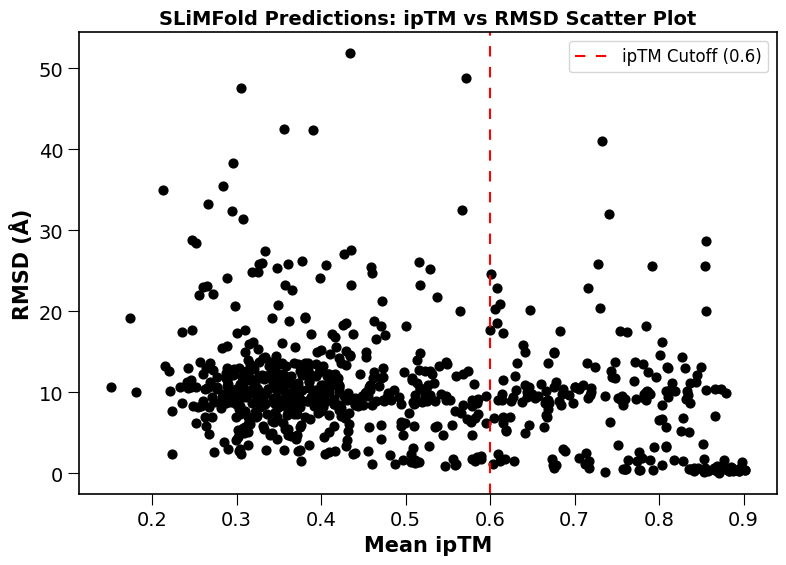

Filtered results saved to /media/pythagoras/895c7a01-1c19-48a4-9803-d0d6a1c1a979/PhD/Pulldown/Paper/Iteration01/Iteration01/all_combined_results_ipTM_Cutoff.csv


In [46]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

# Reset all matplotlib settings to their default values
mpl.rcParams.update(mpl.rcParamsDefault)


# Set the path to the input CSV file and the cutoff for ipTM
input_csv_path = output_all_combined_csv_path  # Input CSV
output_file_name = 'all_combined_results_ipTM_Cutoff.csv'  # Desired output file name
output_filtered_csv_path = os.path.join(output_directory, output_file_name)  # Combine directory and file name

iptm_cutoff = 0.6  # Desired ipTM cutoff value

# Read the combined results CSV
try:
    combined_results_df = pd.read_csv(input_csv_path)
    print(f"Successfully read the CSV file: {input_csv_path}")
except FileNotFoundError:
    print(f"Error: File not found at {input_csv_path}. Please check the path and try again.")
    exit()

def create_scatter_plot(df, title, output_path, iptm_col='Mean_ipTM', rmsd_col='Mean_RMSD'):
    # Extract relevant columns for the scatter plot
    iptm_values = df[iptm_col]
    rmsd_values = df[rmsd_col]  # Use normal RMSD values
    
    # Create the figure and axis explicitly
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.set_title(title, fontsize=14, fontweight='bold')

    # Create scatter plot with black dots
    ax.scatter(iptm_values, rmsd_values, c='black', s=40, alpha=1)

    # Add a vertical red dashed line at ipTM cutoff (0.6)
    ax.axvline(x=0.6, color='red', linestyle=(0, (5, 5)), linewidth=1.5, label='ipTM Cutoff (0.6)')

    # Adjust tick size and font
    ax.tick_params(axis='x', which='major', length=8, labelsize=14)
    ax.tick_params(axis='y', which='major', length=8, labelsize=14)

    # Adjust graph line thickness and set spine colors to black
    ax.spines['top'].set_linewidth(1.2)
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_linewidth(1.2)
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_linewidth(1.2)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['left'].set_color('black')

    # Add labels and legend
    ax.set_xlabel('Mean ipTM', fontsize=15, fontweight='bold')
    ax.set_ylabel('RMSD (Å)', fontsize=15, fontweight='bold')
    ax.legend(fontsize=12)

    # Save the figure in EPS format
    try:
        fig.savefig(output_path, format='eps', dpi=300, bbox_inches='tight')
        print(f"Scatter plot saved as EPS to {output_path}")
    except PermissionError as e:
        print(f"PermissionError: {e}")
        print("Ensure the output path is correct and writable.")

    # Also save the figure in TIFF format
    tiff_output_path = output_path.replace('.eps', '.tif')
    try:
        fig.savefig(tiff_output_path, format='tiff', dpi=300, bbox_inches='tight')
        print(f"Scatter plot saved as TIFF to {tiff_output_path}")
    except PermissionError as e:
        print(f"PermissionError: {e}")
        print("Ensure the output path is correct and writable.")

    plt.show()


# Plot full dataset before filtering
plot_title_full = "SLiMFold Predictions: ipTM vs RMSD Scatter Plot"
output_plot_full_path = os.path.join(output_directory, 'scatter_ipTM_vs_RMSD_Full.eps')  # Save as .eps
create_scatter_plot(combined_results_df, plot_title_full, output_plot_full_path)

# Filter the DataFrame based on the ipTM cutoff
filtered_results_df = combined_results_df[combined_results_df['Mean_ipTM'] >= iptm_cutoff]

# Save the filtered results to a new CSV file
try:
    filtered_results_df.to_csv(output_filtered_csv_path, index=False)
    print(f"Filtered results saved to {output_filtered_csv_path}")
except PermissionError as e:
    print(f"PermissionError: {e}")
    print("Ensure the output path is correct and writable.")


 #### 5. Visualization of 2D and 3D Scatter Plots for Protein Metrics
#####   This script loads protein metric data from a CSV file and visualizes the relationships between three angular dimensions (Mean Delta Angles X, Y, Z) and Mean RMSD values. The data is displayed using 2D scatter plots and an interactive 3D scatter plot with a green-to-red colormap.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Scatter plot saved as EPS to /media/pythagoras/895c7a01-1c19-48a4-9803-d0d6a1c1a979/PhD/Pulldown/Paper/Iteration01/Iteration01/Conformations Landscape - RMSD Colouring.eps
Scatter plot saved as TIFF to /media/pythagoras/895c7a01-1c19-48a4-9803-d0d6a1c1a979/PhD/Pulldown/Paper/Iteration01/Iteration01/Conformations Landscape - RMSD Colouring.tif


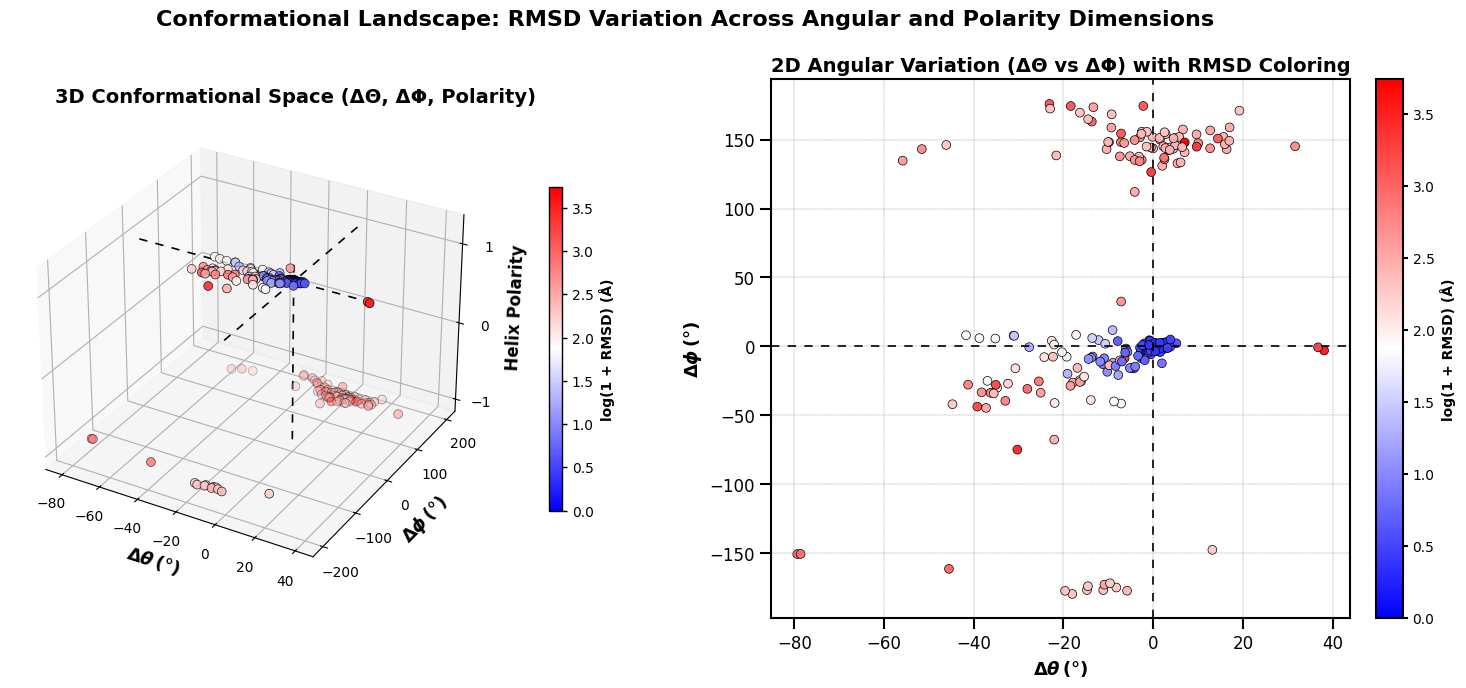

In [55]:
# Enable interactive plotting for visualizing scatter plots (Angles and RMSD)
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap

# Reset all matplotlib settings to their default values
mpl.rcParams.update(mpl.rcParamsDefault)

# Load the CSV file
file_path = output_filtered_csv_path
data = pd.read_csv(file_path)

# Extract relevant columns
mean_delta_theta = data['Mean_Delta_Theta']
mean_delta_phi = data['Mean_Delta_Phi']
mean_helix_polarity = data['Mean_Helix_Polarity']
mean_rmsd = np.log1p(data['Mean_RMSD'])



# Define a green-to-red colormap
blue_white_red = LinearSegmentedColormap.from_list('BlueWhiteRed', ['blue', 'white', 'red'])

# Create a figure
fig = plt.figure(figsize=(18, 7))  # Increase the figure size
fig.suptitle('Conformational Landscape: RMSD Variation Across Angular and Polarity Dimensions', fontsize=16, fontweight='bold')

# 3D Scatter Plot
ax3d = fig.add_subplot(1, 2, 1, projection='3d')  # Second column
scatter3d = ax3d.scatter(
    mean_delta_theta, mean_delta_phi, mean_helix_polarity, 
    c=mean_rmsd, s=40, cmap=blue_white_red, edgecolors='black', linewidths=0.5
)


# Adjust the ticks for the axes
ax3d.set_zticks([-1, 0, 1])  # Helix polarity axis: only +1 and -1
ax3d.set_yticks(np.arange(-200, 201, 100))  # Delta Phi axis: ticks in -100 steps

# Adjust the thickness of the gridlines and axis lines
ax3d.tick_params(axis='x', colors='black', width=1.5)
ax3d.tick_params(axis='y', colors='black', width=1.5)
ax3d.tick_params(axis='z', colors='black', width=1.5)


# Make axis lines black and thicker
ax3d.xaxis._axinfo["axisline"]["color"] = (0,0,0,1)  # Black
ax3d.xaxis._axinfo["axisline"]["linewidth"] = 2.0

ax3d.yaxis._axinfo["axisline"]["color"] = (0,0,0,1)  # Black
ax3d.yaxis._axinfo["axisline"]["linewidth"] = 2.0

ax3d.zaxis._axinfo["axisline"]["color"] = (0,0,0,1)  # Black
ax3d.zaxis._axinfo["axisline"]["linewidth"] = 2.0


# Adjust the line width of the grid and axis lines
ax3d.grid(True, color='black', linewidth=1.5)

# Set labels, grid, and limits
ax3d.set_xlabel(r'$\boldsymbol{\Delta\theta} \, \boldsymbol{(°)}$', fontsize=13, fontweight='bold')
ax3d.set_ylabel(r'$\boldsymbol{\Delta\phi} \, \boldsymbol{(°)}$', fontsize=13, fontweight='bold')
ax3d.set_zlabel('Helix Polarity', fontsize=12, fontweight='bold')
ax3d.set_title('3D Conformational Space (ΔΘ, ΔΦ, Polarity)', fontsize=14, fontweight='bold', x=0.6)

# Add gridlines and axis limits
ax3d.grid(color='gray', linestyle='--', linewidth=0.3)

# Adjust tick size and font
ax3d.tick_params(axis='both', which='major', length=8, width=1.5, labelsize=10)  # Major ticks
ax3d.tick_params(axis='both', which='minor', length=4, width=1.0, labelsize=8)  # Minor ticks (optional)

# Line for Theta = 0 (X = 0, spans full Y and Z range)
ax3d.plot([0, 0], [-200, 200], [1.0, 1.0], color='black', linestyle=(0, (5, 5)), linewidth=1.2)

# Line for Phi = 0 (Y = 0, spans full X and Z range)
ax3d.plot([-80, 40], [0, 0], [1.0, 1.0], color='black', linestyle=(0, (5, 5)), linewidth=1.2)

# Line for Polarity = 1 (Z = 1, spans full X and Y range)
ax3d.plot([0, 0], [0, 0], [-1, 1.2], color='black', linestyle=(0, (5, 5)), linewidth=1.2)

# Add color bar for 3D plot
cbar3d = fig.colorbar(scatter3d, ax=ax3d, shrink=0.6, aspect=25, pad=0.1)  # Adjust shrink to make the 3D bar consistent
cbar3d.set_label("log(1 + RMSD) (Å)", fontsize=10, fontweight='bold')
cbar3d.ax.tick_params(width=1)  # Make color bar ticks thicker
cbar3d.outline.set_linewidth(1) 
cbar3d.outline.set_edgecolor('black')  # Adjust color bar outline thickness

# 2D Scatter Plot
ax2d = fig.add_subplot(1, 2, 2)  # First column
scatter2d = ax2d.scatter(
    mean_delta_theta, mean_delta_phi,
    c=mean_rmsd, s=40, cmap=blue_white_red, edgecolors='black', linewidths=0.5
)
ax2d.set_xlabel(r'$\boldsymbol{\Delta\theta} \, \boldsymbol{(°)}$', fontsize=13, fontweight='bold')
ax2d.set_ylabel(r'$\boldsymbol{\Delta\phi} \, \boldsymbol{(°)}$', fontsize=13, fontweight='bold')
ax2d.set_title('2D Angular Variation (ΔΘ vs ΔΦ) with RMSD Coloring', fontsize=14, fontweight='bold')
ax2d.grid(color='gray', linestyle='--', linewidth=0.3)

ax2d.axhline(0, color='black', linestyle=(0, (5, 5)), linewidth=1.2)  # Dashed Phi=0 line
ax2d.axvline(0, color='black', linestyle=(0, (5, 5)), linewidth=1.2)  # Dashed Theta=0 line

# Adjust tick size and font
ax2d.tick_params(axis='both', which='major', length=8, width=1.5, labelsize=12)  # Major ticks
ax2d.tick_params(axis='both', which='minor', length=4, width=1.0, labelsize=10)  # Minor ticks (optional)

# Adjust graph line thickness and set spine colors to black
ax2d.spines['top'].set_linewidth(1.5)
ax2d.spines['top'].set_color('black')
ax2d.spines['right'].set_linewidth(1.5)
ax2d.spines['right'].set_color('black')
ax2d.spines['bottom'].set_linewidth(1.5)
ax2d.spines['bottom'].set_color('black')
ax2d.spines['left'].set_linewidth(1.5)
ax2d.spines['left'].set_color('black')


# Add color bar for 2D plot
cbar2d = fig.colorbar(scatter2d, ax=ax2d, orientation='vertical', fraction=0.046, pad=0.04)
cbar2d.set_label("log(1 + RMSD) (Å)", fontsize=10, fontweight='bold')
cbar2d.ax.tick_params(width=1.5)  # Make color bar ticks thicker
cbar2d.outline.set_linewidth(1.5)  # Adjust color bar outline thickness
cbar2d.outline.set_edgecolor('black')  # Set color bar outline color
# Save and show the figure
output_plot_full_path = os.path.join(output_directory, 'Conformations Landscape - RMSD Colouring.eps')

# Save the figure in EPS format
try:
    plt.savefig(output_plot_full_path, format='eps', dpi=300, bbox_inches='tight')
    print(f"Scatter plot saved as EPS to {output_plot_full_path}")
except PermissionError as e:
    print(f"PermissionError: {e}")
    print("Ensure the output path is correct and writable.")

# Also save the figure in TIFF format
tiff_output_path = output_plot_full_path.replace('.eps', '.tif')
try:
    plt.savefig(tiff_output_path, format='tiff', dpi=300, bbox_inches='tight')
    print(f"Scatter plot saved as TIFF to {tiff_output_path}")
except PermissionError as e:
    print(f"PermissionError: {e}")
    print("Ensure the output path is correct and writable.")

plt.show()


#### 6. Optimizing Clustering Parameters with differenet Algorithms and Evaluating Cluster Quality
##### This script searches for the optimum clustering parameters of KMeans, Agglomerative and HDBScan  and evaluates cluster quality using various metrics such as silhouette score, Calinski-Harabasz score, and Davies-Bouldin score. The results are visualized to help determine the best clustering configuration. Insights from these scores can guide the selection of n cluster size, min_cluster_size and min_samples.

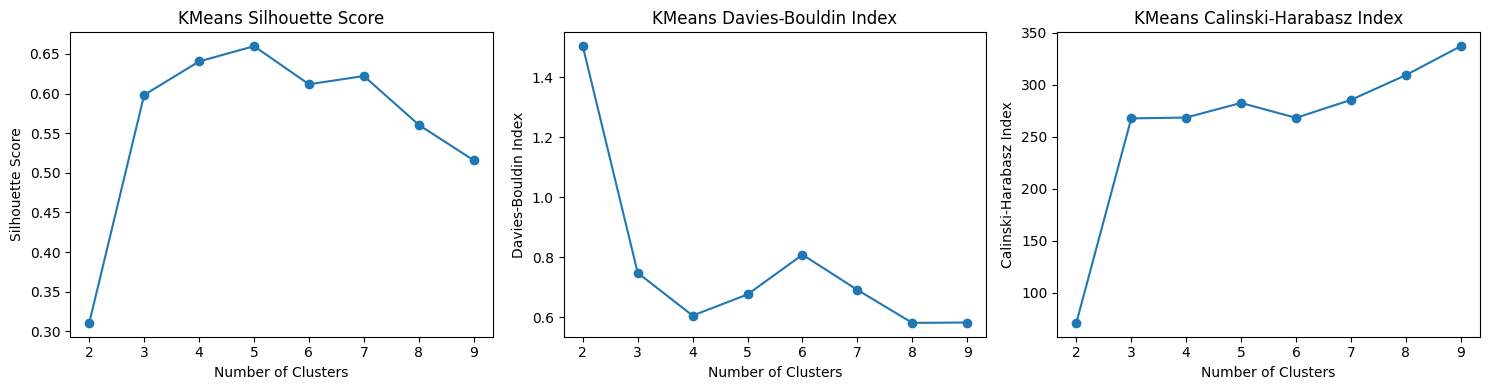

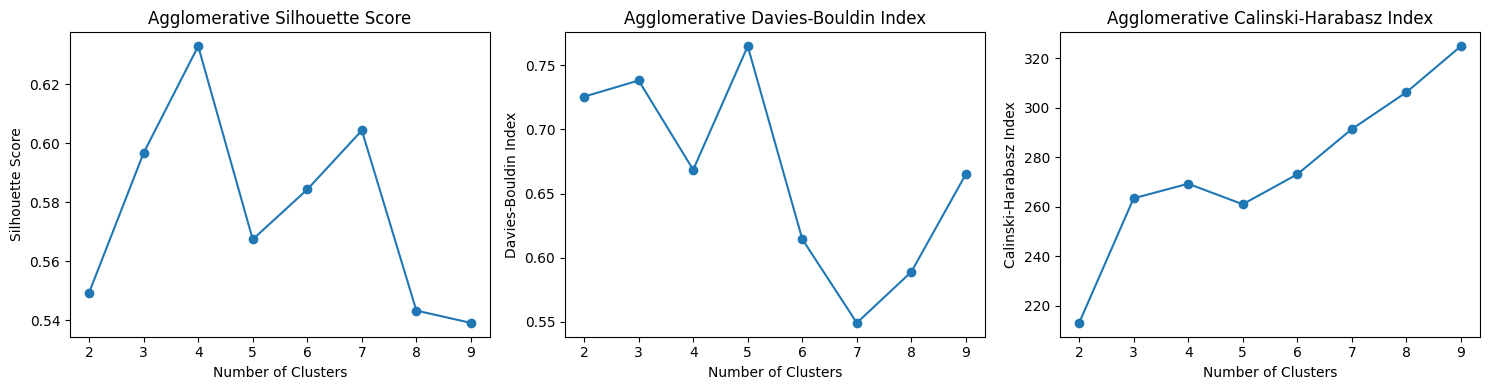

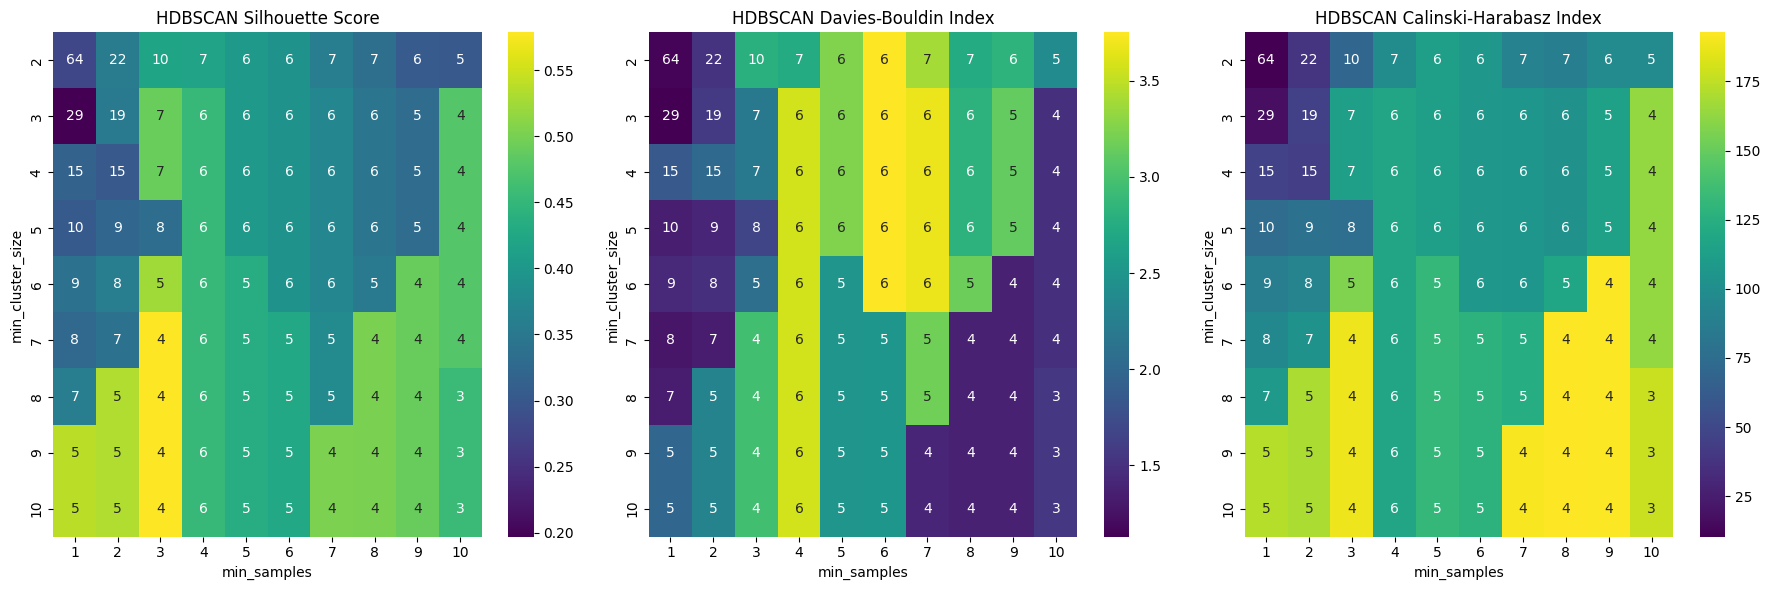

Best Cluster Configurations:

KMeans:
  Best Silhouette Score: (5, 0.6598344032006063)
  Best Davies-Bouldin Index: (8, 0.5813848333995943)
  Best Calinski-Harabasz Index: (9, 337.2888759650082)

Agglomerative Clustering:
  Best Silhouette Score: (4, 0.6328499594649429)
  Best Davies-Bouldin Index: (7, 0.5492785026457435)
  Best Calinski-Harabasz Index: (9, 324.8685242485851)

HDBSCAN:
  Best Silhouette Score: min_cluster_size=7, min_samples=3, score=0.5788, clusters=4
  Best Davies-Bouldin Index: min_cluster_size=3, min_samples=1, score=1.1299, clusters=29
  Best Calinski-Harabasz Index: min_cluster_size=7, min_samples=8, score=192.7655, clusters=4


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import clustering algorithms and evaluation metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

import hdbscan

# Set the file path
file_path = output_filtered_csv_path

# Function to determine the best cluster configuration based on metrics
def get_best_cluster_config(metric_values, param_values, metric_name, optimize='max'):
    if optimize == 'max':
        best_index = np.nanargmax(metric_values)
    elif optimize == 'min':
        best_index = np.nanargmin(metric_values)
    else:
        raise ValueError("Optimize must be 'max' or 'min'")
    return param_values[best_index], metric_values[best_index]

# Function to get the best configuration and number of clusters from grid values
def get_best_from_grid_with_clusters(grid_values, clusters_grid, param_x, param_y, optimize='max'):
    if optimize == 'max':
        best_index = np.nanargmax(grid_values)
    elif optimize == 'min':
        best_index = np.nanargmin(grid_values)
    else:
        raise ValueError("Optimize must be 'max' or 'min'")
    best_coords = np.unravel_index(best_index, grid_values.shape)
    return param_x[best_coords[0]], param_y[best_coords[1]], grid_values[best_coords], clusters_grid[best_coords]


# Read the data
data = pd.read_csv(file_path)

# Extract relevant columns
mean_delta_theta = data['Mean_Delta_Theta']
mean_delta_phi = data['Mean_Delta_Phi']
mean_helix_polarity = data['Mean_Helix_Polarity']
mean_rmsd = np.log1p(data['Mean_RMSD'])

# Combine features into a single DataFrame
X = pd.DataFrame({
    'Mean_Delta_Theta': mean_delta_theta,
    'Mean_Delta_Phi': mean_delta_phi,
    'Mean_Helix_Polarity': mean_helix_polarity,
    'Mean_RMSD': mean_rmsd
})

# Handle missing values (if any)
X = X.dropna()

feature_weights = {
    'Mean_Delta_Theta': 1,   # Adjust weights based on importance
    'Mean_Delta_Phi': 1,
    'Mean_Helix_Polarity': 1,
    'Mean_RMSD': 1
}

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert X_scaled back to DataFrame for easy manipulation
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Apply feature weights
for feature in X_scaled_df.columns:
    weight = feature_weights.get(feature)
    X_scaled_df[feature] *= weight

# Convert back to NumPy array for clustering algorithms
X_weighted = X_scaled_df.values

# Function to evaluate clustering
def evaluate_clustering(X, labels):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f'Number of clusters: {n_clusters}')
    if n_clusters > 1 and n_clusters < len(labels):
        silhouette_avg = silhouette_score(X, labels)
        davies_bouldin = davies_bouldin_score(X, labels)
        calinski_harabasz = calinski_harabasz_score(X, labels)
        print(f'Silhouette Score: {silhouette_avg:.4f}')
        print(f'Davies-Bouldin Index: {davies_bouldin:.4f}')
        print(f'Calinski-Harabasz Index: {calinski_harabasz:.4f}')
    else:
        print('Clustering did not produce meaningful clusters.')

# KMeans clustering
# Initialize lists to store evaluation metrics
kmeans_n_clusters = range(2, 10)
kmeans_silhouette = []
kmeans_davies_bouldin = []
kmeans_calinski_harabasz = []

for n_clusters in kmeans_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_weighted)
    silhouette_avg = silhouette_score(X_weighted, labels)
    davies_bouldin = davies_bouldin_score(X_weighted, labels)
    calinski_harabasz = calinski_harabasz_score(X_weighted, labels)
    kmeans_silhouette.append(silhouette_avg)
    kmeans_davies_bouldin.append(davies_bouldin)
    kmeans_calinski_harabasz.append(calinski_harabasz)

# Plotting the metrics
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(kmeans_n_clusters, kmeans_silhouette, marker='o')
plt.title('KMeans Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.subplot(1, 3, 2)
plt.plot(kmeans_n_clusters, kmeans_davies_bouldin, marker='o')
plt.title('KMeans Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')

plt.subplot(1, 3, 3)
plt.plot(kmeans_n_clusters, kmeans_calinski_harabasz, marker='o')
plt.title('KMeans Calinski-Harabasz Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Index')

plt.tight_layout()
plt.show()

# Agglomerative Clustering
# Initialize lists
agg_n_clusters = range(2, 10)
agg_silhouette = []
agg_davies_bouldin = []
agg_calinski_harabasz = []

for n_clusters in agg_n_clusters:
    agg = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agg.fit_predict(X_weighted)
    silhouette_avg = silhouette_score(X_weighted, labels)
    davies_bouldin = davies_bouldin_score(X_weighted, labels)
    calinski_harabasz = calinski_harabasz_score(X_weighted, labels)
    agg_silhouette.append(silhouette_avg)
    agg_davies_bouldin.append(davies_bouldin)
    agg_calinski_harabasz.append(calinski_harabasz)

# Plotting the metrics
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(agg_n_clusters, agg_silhouette, marker='o')
plt.title('Agglomerative Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.subplot(1, 3, 2)
plt.plot(agg_n_clusters, agg_davies_bouldin, marker='o')
plt.title('Agglomerative Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')

plt.subplot(1, 3, 3)
plt.plot(agg_n_clusters, agg_calinski_harabasz, marker='o')
plt.title('Agglomerative Calinski-Harabasz Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Index')

plt.tight_layout()
plt.show()

# HDBSCAN
import hdbscan

# Define a range of min_cluster_size and min_samples values to test
min_cluster_size_values = range(2, 11)
min_samples_values = range(1, 11)

# Prepare a grid to store the metrics
hdbscan_silhouette_scores = np.zeros((len(min_cluster_size_values), len(min_samples_values)))
hdbscan_davies_bouldin_scores = np.zeros((len(min_cluster_size_values), len(min_samples_values)))
hdbscan_calinski_harabasz_scores = np.zeros((len(min_cluster_size_values), len(min_samples_values)))
hdbscan_n_clusters_grid = np.zeros((len(min_cluster_size_values), len(min_samples_values)))

for i, min_cluster_size in enumerate(min_cluster_size_values):
    for j, min_samples in enumerate(min_samples_values):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        labels = clusterer.fit_predict(X_weighted)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        hdbscan_n_clusters_grid[i, j] = n_clusters
        if n_clusters > 1 and n_clusters < len(labels):
            silhouette_avg = silhouette_score(X_weighted, labels)
            davies_bouldin = davies_bouldin_score(X_weighted, labels)
            calinski_harabasz = calinski_harabasz_score(X_weighted, labels)
            hdbscan_silhouette_scores[i, j] = silhouette_avg
            hdbscan_davies_bouldin_scores[i, j] = davies_bouldin
            hdbscan_calinski_harabasz_scores[i, j] = calinski_harabasz
        else:
            hdbscan_silhouette_scores[i, j] = np.nan
            hdbscan_davies_bouldin_scores[i, j] = np.nan
            hdbscan_calinski_harabasz_scores[i, j] = np.nan

# Plot heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(hdbscan_silhouette_scores, xticklabels=min_samples_values, yticklabels=min_cluster_size_values, ax=axes[0], cmap='viridis', annot=hdbscan_n_clusters_grid.astype(int), fmt='d')
axes[0].set_title('HDBSCAN Silhouette Score')
axes[0].set_xlabel('min_samples')
axes[0].set_ylabel('min_cluster_size')

sns.heatmap(hdbscan_davies_bouldin_scores, xticklabels=min_samples_values, yticklabels=min_cluster_size_values, ax=axes[1], cmap='viridis', annot=hdbscan_n_clusters_grid.astype(int), fmt='d')
axes[1].set_title('HDBSCAN Davies-Bouldin Index')
axes[1].set_xlabel('min_samples')
axes[1].set_ylabel('min_cluster_size')

sns.heatmap(hdbscan_calinski_harabasz_scores, xticklabels=min_samples_values, yticklabels=min_cluster_size_values, ax=axes[2], cmap='viridis', annot=hdbscan_n_clusters_grid.astype(int), fmt='d')
axes[2].set_title('HDBSCAN Calinski-Harabasz Index')
axes[2].set_xlabel('min_samples')
axes[2].set_ylabel('min_cluster_size')

plt.tight_layout()
plt.show()

# Best configurations for KMeans
best_kmeans_silhouette = get_best_cluster_config(kmeans_silhouette, kmeans_n_clusters, 'Silhouette', optimize='max')
best_kmeans_davies_bouldin = get_best_cluster_config(kmeans_davies_bouldin, kmeans_n_clusters, 'Davies-Bouldin', optimize='min')
best_kmeans_calinski_harabasz = get_best_cluster_config(kmeans_calinski_harabasz, kmeans_n_clusters, 'Calinski-Harabasz', optimize='max')

# Best configurations for Agglomerative Clustering
best_agg_silhouette = get_best_cluster_config(agg_silhouette, agg_n_clusters, 'Silhouette', optimize='max')
best_agg_davies_bouldin = get_best_cluster_config(agg_davies_bouldin, agg_n_clusters, 'Davies-Bouldin', optimize='min')
best_agg_calinski_harabasz = get_best_cluster_config(agg_calinski_harabasz, agg_n_clusters, 'Calinski-Harabasz', optimize='max')



# Best configurations for HDBSCAN
best_hdbscan_silhouette = get_best_from_grid_with_clusters(
    hdbscan_silhouette_scores, hdbscan_n_clusters_grid, min_cluster_size_values, min_samples_values, optimize='max'
)
best_hdbscan_davies_bouldin = get_best_from_grid_with_clusters(
    hdbscan_davies_bouldin_scores, hdbscan_n_clusters_grid, min_cluster_size_values, min_samples_values, optimize='min'
)
best_hdbscan_calinski_harabasz = get_best_from_grid_with_clusters(
    hdbscan_calinski_harabasz_scores, hdbscan_n_clusters_grid, min_cluster_size_values, min_samples_values, optimize='max'
)

# Print best configurations including the number of clusters
print("Best Cluster Configurations:")
print("\nKMeans:")
print(f"  Best Silhouette Score: {best_kmeans_silhouette}")
print(f"  Best Davies-Bouldin Index: {best_kmeans_davies_bouldin}")
print(f"  Best Calinski-Harabasz Index: {best_kmeans_calinski_harabasz}")

print("\nAgglomerative Clustering:")
print(f"  Best Silhouette Score: {best_agg_silhouette}")
print(f"  Best Davies-Bouldin Index: {best_agg_davies_bouldin}")
print(f"  Best Calinski-Harabasz Index: {best_agg_calinski_harabasz}")

print("\nHDBSCAN:")
print(f"  Best Silhouette Score: min_cluster_size={best_hdbscan_silhouette[0]}, min_samples={best_hdbscan_silhouette[1]}, "
      f"score={best_hdbscan_silhouette[2]:.4f}, clusters={int(best_hdbscan_silhouette[3])}")
print(f"  Best Davies-Bouldin Index: min_cluster_size={best_hdbscan_davies_bouldin[0]}, min_samples={best_hdbscan_davies_bouldin[1]}, "
      f"score={best_hdbscan_davies_bouldin[2]:.4f}, clusters={int(best_hdbscan_davies_bouldin[3])}")
print(f"  Best Calinski-Harabasz Index: min_cluster_size={best_hdbscan_calinski_harabasz[0]}, min_samples={best_hdbscan_calinski_harabasz[1]}, "
      f"score={best_hdbscan_calinski_harabasz[2]:.4f}, clusters={int(best_hdbscan_calinski_harabasz[3])}")

#### 7A. Clustering with KMeans

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


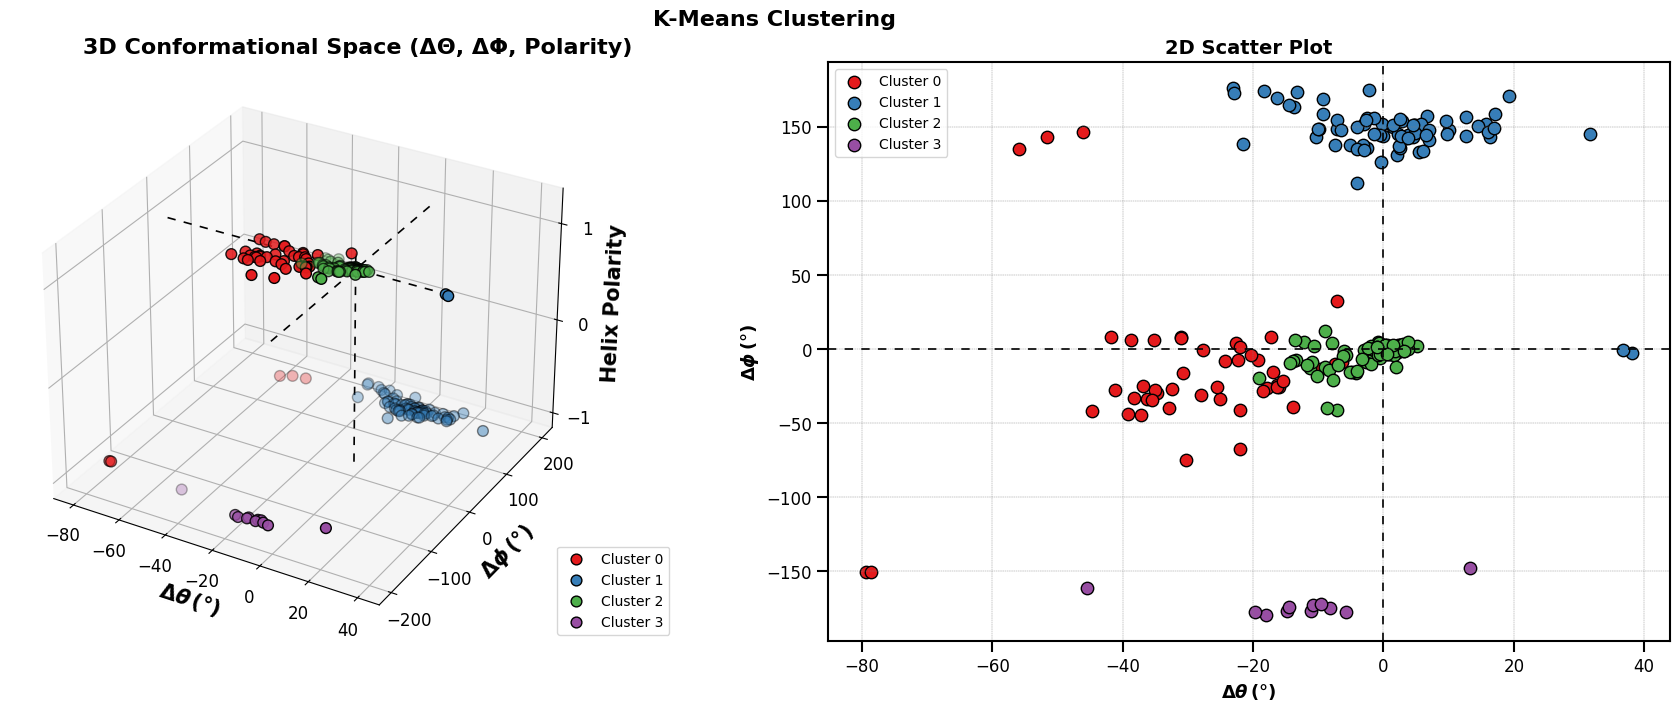

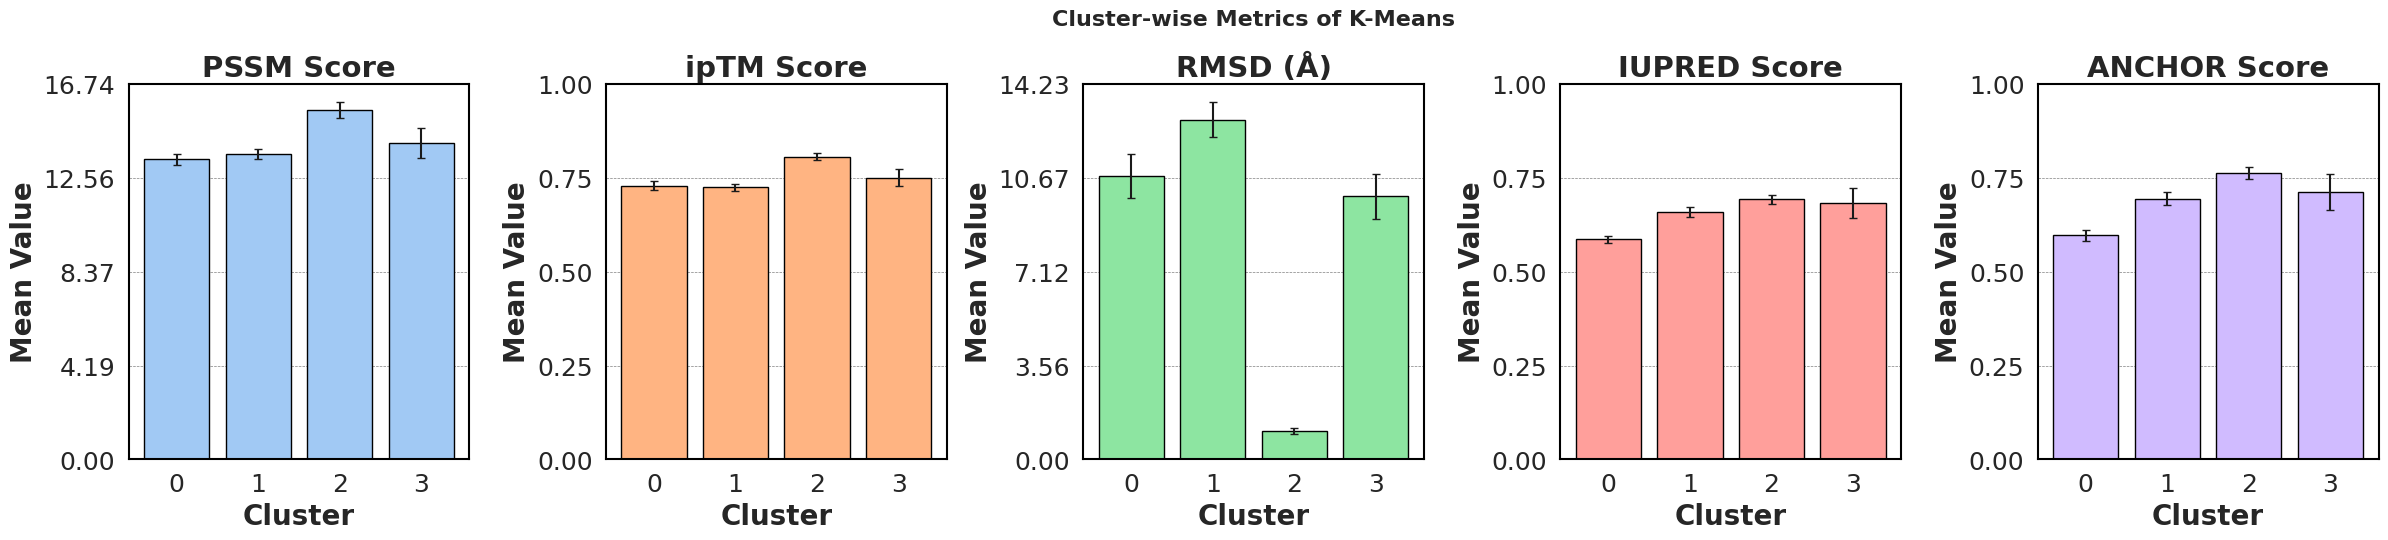

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Import clustering algorithms
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# Reset all matplotlib settings to their default values
mpl.rcParams.update(mpl.rcParamsDefault)

#Define the numbers of clusters after running the different scores above 
clusters = 4

# Read the data
data = pd.read_csv(file_path)

# Extract relevant columns
mean_delta_theta = data['Mean_Delta_Theta']
mean_delta_phi = data['Mean_Delta_Phi']
mean_helix_polarity = data['Mean_Helix_Polarity']
mean_rmsd = np.log1p(data['Mean_RMSD'])

# Combine features into a single DataFrame
X = pd.DataFrame({
    'Mean_Delta_Theta': mean_delta_theta,
    'Mean_Delta_Phi': mean_delta_phi,
    'Mean_Helix_Polarity': mean_helix_polarity,
    'Mean_RMSD': mean_rmsd
})

# Handle missing values (if any)
X = X.dropna()

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert X_scaled back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Define feature weights (replace these with your actual weights)
feature_weights = {
    'Mean_Delta_Theta': 1,    # Adjust weights based on your PCA results
    'Mean_Delta_Phi': 1,
    'Mean_Helix_Polarity': 1,
    'Mean_RMSD': 1
}

# Apply feature weights
for feature in X_scaled_df.columns:
    weight = feature_weights.get(feature)
    X_scaled_df[feature] *= weight

# Convert back to NumPy array for clustering algorithms
X_weighted = X_scaled_df.values

# Perform K-means Clustering with 4 clusters
kmeans = KMeans(n_clusters=clusters, random_state=42)
labels = kmeans.fit_predict(X_weighted)

# Add cluster labels to data
data['Cluster'] = labels

# Plotting parameters
colors = sns.color_palette('Set1', n_colors=clusters)  # Colors for 4 clusters

# Create a figure with a 2D plot and a 3D plot
fig = plt.figure(figsize=(18, 7), constrained_layout=True)

# Add a central title
fig.suptitle('K-Means Clustering', fontsize=16, fontweight='bold')


# 2D Plot: K-means Clustering
ax2d = fig.add_subplot(1, 2, 2)
for cluster in range(len(np.unique(labels))):
    cluster_data = data[data['Cluster'] == cluster]
    ax2d.scatter(cluster_data['Mean_Delta_Theta'], cluster_data['Mean_Delta_Phi'],
                color=colors[cluster], edgecolor='black', s=80, label=f'Cluster {cluster}')
ax2d.set_xlabel(r'$\boldsymbol{\Delta\theta} \, \boldsymbol{(°)}$', fontsize=13, fontweight='bold')
ax2d.set_ylabel(r'$\boldsymbol{\Delta\phi} \, \boldsymbol{(°)}$', fontsize=13, fontweight='bold')
ax2d.set_title('2D Scatter Plot', fontsize=14, fontweight='bold')
ax2d.grid(color='gray', linestyle='--', linewidth=0.3)

ax2d.axhline(0, color='black', linestyle=(0, (5, 5)), linewidth=1.2)  # Dashed Phi=0 line
ax2d.axvline(0, color='black', linestyle=(0, (5, 5)), linewidth=1.2)  # Dashed Theta=0 line

# Adjust tick size and font
ax2d.tick_params(axis='both', which='major', length=8, width=1.5, labelsize=12)  # Major ticks
ax2d.tick_params(axis='both', which='minor', length=4, width=1.0, labelsize=10)  # Minor ticks (optional)

# Adjust graph (line) thickness
# Adjust graph line thickness and set spine colors to black
ax2d.spines['top'].set_linewidth(1.5)
ax2d.spines['top'].set_color('black')
ax2d.spines['right'].set_linewidth(1.5)
ax2d.spines['right'].set_color('black')
ax2d.spines['bottom'].set_linewidth(1.5)
ax2d.spines['bottom'].set_color('black')
ax2d.spines['left'].set_linewidth(1.5)
ax2d.spines['left'].set_color('black')

ax2d.legend()


# 3D Scatter Plot
ax3d = fig.add_subplot(1, 2, 1, projection='3d')

# Plot clusters in 3D
for cluster in range(len(np.unique(labels))):
    cluster_data = data[data['Cluster'] == cluster]
    ax3d.scatter(cluster_data['Mean_Delta_Theta'], 
                 cluster_data['Mean_Delta_Phi'], 
                 cluster_data['Mean_Helix_Polarity'],
                 color=colors[cluster], edgecolor='black', s=60, label=f'Cluster {cluster}')

# Set labels for the axes and the title
ax3d.set_xlabel(r'$\boldsymbol{\Delta\theta} \, \boldsymbol{(°)}$', fontsize=15, fontweight='bold')
ax3d.set_ylabel(r'$\boldsymbol{\Delta\phi} \, \boldsymbol{(°)}$', fontsize=15, fontweight='bold')
ax3d.set_zlabel('Helix Polarity', fontsize=15, fontweight='bold')
ax3d.set_title('3D Conformational Space (ΔΘ, ΔΦ, Polarity)', fontsize=16, fontweight='bold', x=0.6)

# Adjust the thickness of the gridlines and axis lines
ax3d.tick_params(axis='x', colors='black', width=1.5)
ax3d.tick_params(axis='y', colors='black', width=1.5)
ax3d.tick_params(axis='z', colors='black', width=1.5)

ax3d.grid(True, linewidth=1.5)
ax3d.grid(color='gray', linestyle='--', linewidth=0.3)

# Make axis lines black and thicker
ax3d.xaxis._axinfo["axisline"]["color"] = (0,0,0,1)  # Black
ax3d.xaxis._axinfo["axisline"]["linewidth"] = 2.0

ax3d.yaxis._axinfo["axisline"]["color"] = (0,0,0,1)  # Black
ax3d.yaxis._axinfo["axisline"]["linewidth"] = 2.0

ax3d.zaxis._axinfo["axisline"]["color"] = (0,0,0,1)  # Black
ax3d.zaxis._axinfo["axisline"]["linewidth"] = 2.0

# Adjust the ticks for the axes
ax3d.set_zticks([-1, 0, 1])  # Helix polarity axis: only +1 and -1
ax3d.set_yticks(np.arange(-200, 201, 100))  # Delta Phi axis: ticks in -100 steps

# Adjust tick size and font
ax3d.tick_params(axis='both', which='major', length=8, width=1.5, labelsize=12)
ax3d.tick_params(axis='both', which='minor', length=4, width=1.0, labelsize=10)

# Reference lines
ax3d.plot([0, 0], [-200, 200], [1.0, 1.0], color='black', linestyle=(0, (5, 5)), linewidth=1.2)
ax3d.plot([-80, 40], [0, 0], [1.0, 1.0], color='black', linestyle=(0, (5, 5)), linewidth=1.2)
ax3d.plot([0, 0], [0, 0], [-1, 1.2], color='black', linestyle=(0, (5, 5)), linewidth=1.2)

#Add legend
ax3d.legend(loc='lower right', fontsize=10, bbox_to_anchor=(1.15, 0))

# Save the updated DataFrame to a CSV file
output_file_name = 'all_combined_results_with_Kmeans_clusters.csv'  # Desired output file name
output_filtered_csv_path = os.path.join(output_directory, output_file_name)  # Combine directory and file name
data.to_csv(output_filtered_csv_path, index=False)

# Save the figure (optional)
fig.savefig(os.path.join(output_directory, "K-Means_Cluster.eps"), format='eps', dpi=300, bbox_inches="tight")
fig.savefig(os.path.join(output_directory, "K-Means_Cluster.tif"), format='tif', dpi=300, bbox_inches="tight")

# Read the clustered data
data = pd.read_csv(output_filtered_csv_path)  # Replace with your actual file path

# Relevant columns
metrics = [
    "PSSM_Score",
    "Mean_ipTM",
    "Mean_RMSD",
#    "Helix_Score",
#    "Coil_Score",
#    "Strand_Score",
    "IUPRED_Score",
    "ANCHOR_Score",
#    "Mean_Delta_Theta",
#    "Mean_Delta_Phi",
#    "Mean_Helix_Polarity",
]

# Ensure 'Cluster' column exists
if "Cluster" not in data.columns:
    raise ValueError("The 'Cluster' column is not in the dataset. Please check the input file.")

# Group by cluster and calculate mean and SEM
cluster_stats = data.groupby("Cluster")[metrics].agg(["mean", "sem"]).reset_index()

# Flatten MultiIndex columns for easier referencing
cluster_stats.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in cluster_stats.columns]

# Custom y-axis limits for certain metrics
custom_y_limits = {
    "Mean_ipTM": (0, 1),           # Example: [Min, Max]
    "Helix_Score": (0, 1),
    "Coil_Score": (0, 1),
    "Strand_Score": (0, 1),
    "IUPRED_Score": (0, 1),
    "ANCHOR_Score": (0, 1),
    "Mean_Delta_Theta": (-180, 180),
    "Mean_Delta_Phi": (-180, 180),
    "Mean_Helix_Polarity": (-1.1, 1.1),
}

# Custom titles for metrics with Greek letters and descriptive names
metric_titles = {
    "PSSM_Score": r"PSSM Score",
    "Mean_ipTM": r"ipTM Score",
    "Mean_RMSD": r"RMSD (Å)",  # Example: Adding Å for RMSD in angstroms
    "Helix_Score": r"Helix Score",
    "Coil_Score": r"Coil Score",
    "Strand_Score": r"Strand Score",
    "IUPRED_Score": r"IUPRED Score",
    "ANCHOR_Score": r"ANCHOR Score",
    "Mean_Delta_Theta": r"$\boldsymbol{\Delta\theta} \, \boldsymbol{(°)}$",  # Greek delta for Theta
    "Mean_Delta_Phi": r"$\boldsymbol{\Delta\phi} \, \boldsymbol{(°)}$",      # Greek delta for Phi
    "Mean_Helix_Polarity": r"Helix Polarity",
}

# Plotting
sns.set(style="whitegrid")  # Use a clean white grid for the background
fig, axes = plt.subplots(1, len(metrics), figsize=(25, 5))

# Adjust subplot spacing
fig.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15, wspace=0.4)  # Increase wspace for horizontal spacing

# Define a pastel color palette
palette = sns.color_palette("pastel", n_colors=len(metrics))

for i, metric in enumerate(metrics):
    ax = axes[i]
    means = cluster_stats[f"{metric}_mean"]
    sems = cluster_stats[f"{metric}_sem"]
    clusters = cluster_stats["Cluster"]
    
    # Bar plot with error bars
    bars = ax.bar(clusters, means, yerr=sems, capsize=3, color=palette[i], edgecolor="black")
    
    # Set title and labels
    title = metric_titles.get(metric, metric).replace("_", " ")
    ax.set_title(title, fontsize=21, fontweight="bold")
    ax.set_xlabel("Cluster", fontsize=20, fontweight="bold")
    ax.set_ylabel("Mean Value", fontsize=20, fontweight="bold")
    
    # Apply custom y-axis limits if specified
    if metric in custom_y_limits:
        ymin, ymax = custom_y_limits[metric]
        ax.set_ylim(ymin, ymax)
    
    # Explicitly set x-axis ticks and labels
    ax.set_xticks(clusters)  # Set ticks at the cluster positions
    ax.set_xticklabels(clusters.astype(int), fontsize=18)  # Ensure labels match the cluster numbers
    
    # Explicitly set y-axis ticks
    yticks = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 5)  # Generate 5 evenly spaced ticks
    ax.set_yticks(yticks)  # Set y-ticks
    ax.set_yticklabels([f"{tick:.2f}" for tick in yticks], fontsize=18)  # Format y-tick labels
    
    # Enable grid only for the y-axis (horizontal lines)
    ax.grid(axis="y", color="gray", linestyle="--", linewidth=0.5)  # Horizontal lines only
    ax.grid(axis="x", visible=False)  # Disable x-axis grid lines


    # Adjust the line thickness and colors
    ax.spines['bottom'].set_linewidth(1.5)  
    ax.spines['left'].set_linewidth(1.5)    
    ax.spines['right'].set_linewidth(1.5)   
    ax.spines['top'].set_linewidth(1.5)     

    ax.spines['bottom'].set_color('black')  
    ax.spines['left'].set_color('black')    
    ax.spines['right'].set_color('black')   
    ax.spines['top'].set_color('black')     

# Add a central title
fig.suptitle("Cluster-wise Metrics of K-Means", fontsize=18, fontweight="bold", y=1.02)

# Add a central title
fig.suptitle("Cluster-wise Metrics of K-Means", fontsize=16, fontweight="bold", y=1.05)

# Save the figure (optional)
fig.savefig(os.path.join(output_directory, "K-Means_Cluster_Metadata.eps"), format='eps', dpi=300, bbox_inches="tight")
fig.savefig(os.path.join(output_directory, "K-Means_Cluster_Metadata.tif"), format='tif', dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

# shift y axis tic labels with ha='right' to align 
# correct the format of the figure when creating it (f.e. always 18 to 7) 

#### 7B. Clustering with Agglomerative

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


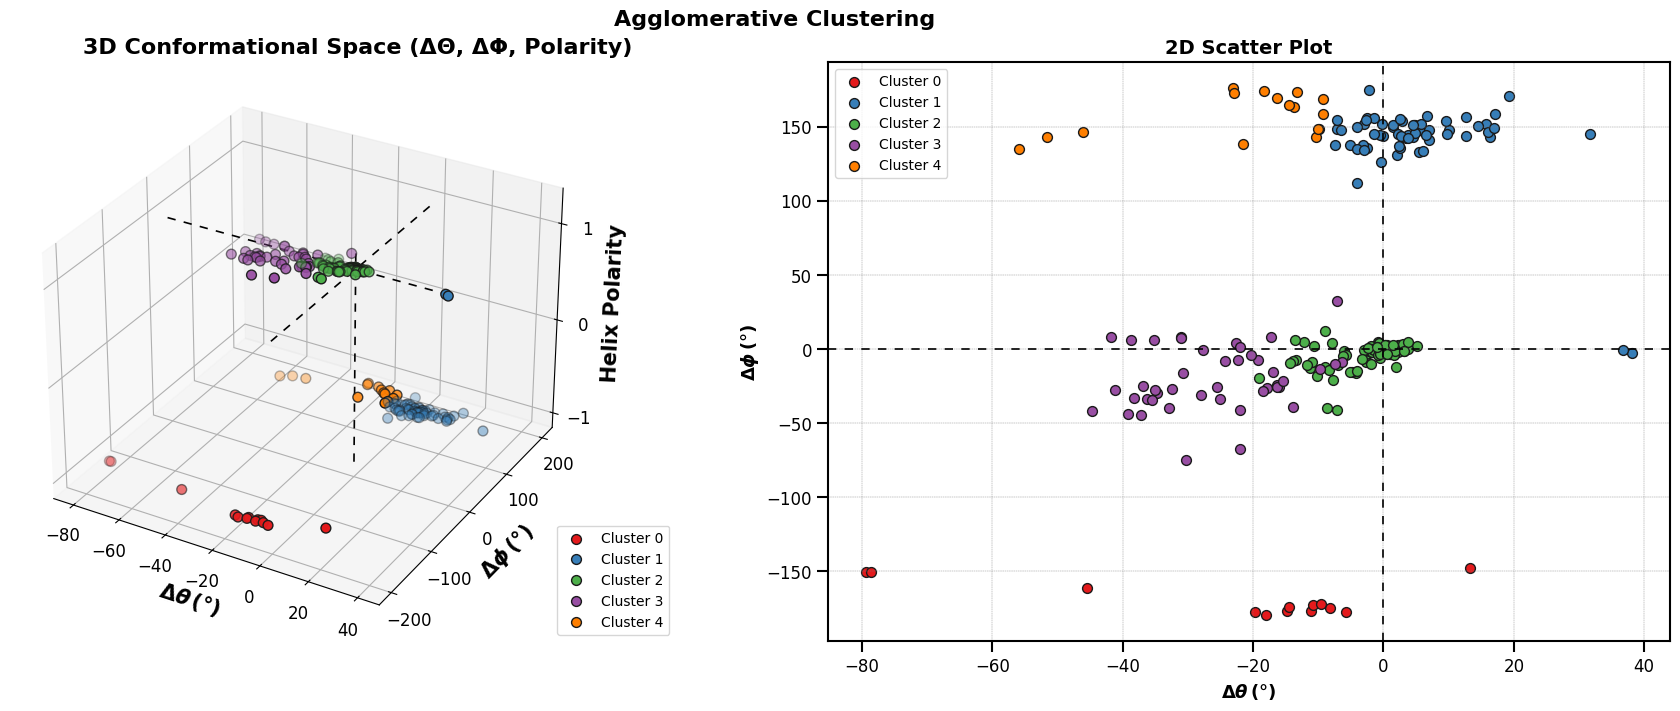

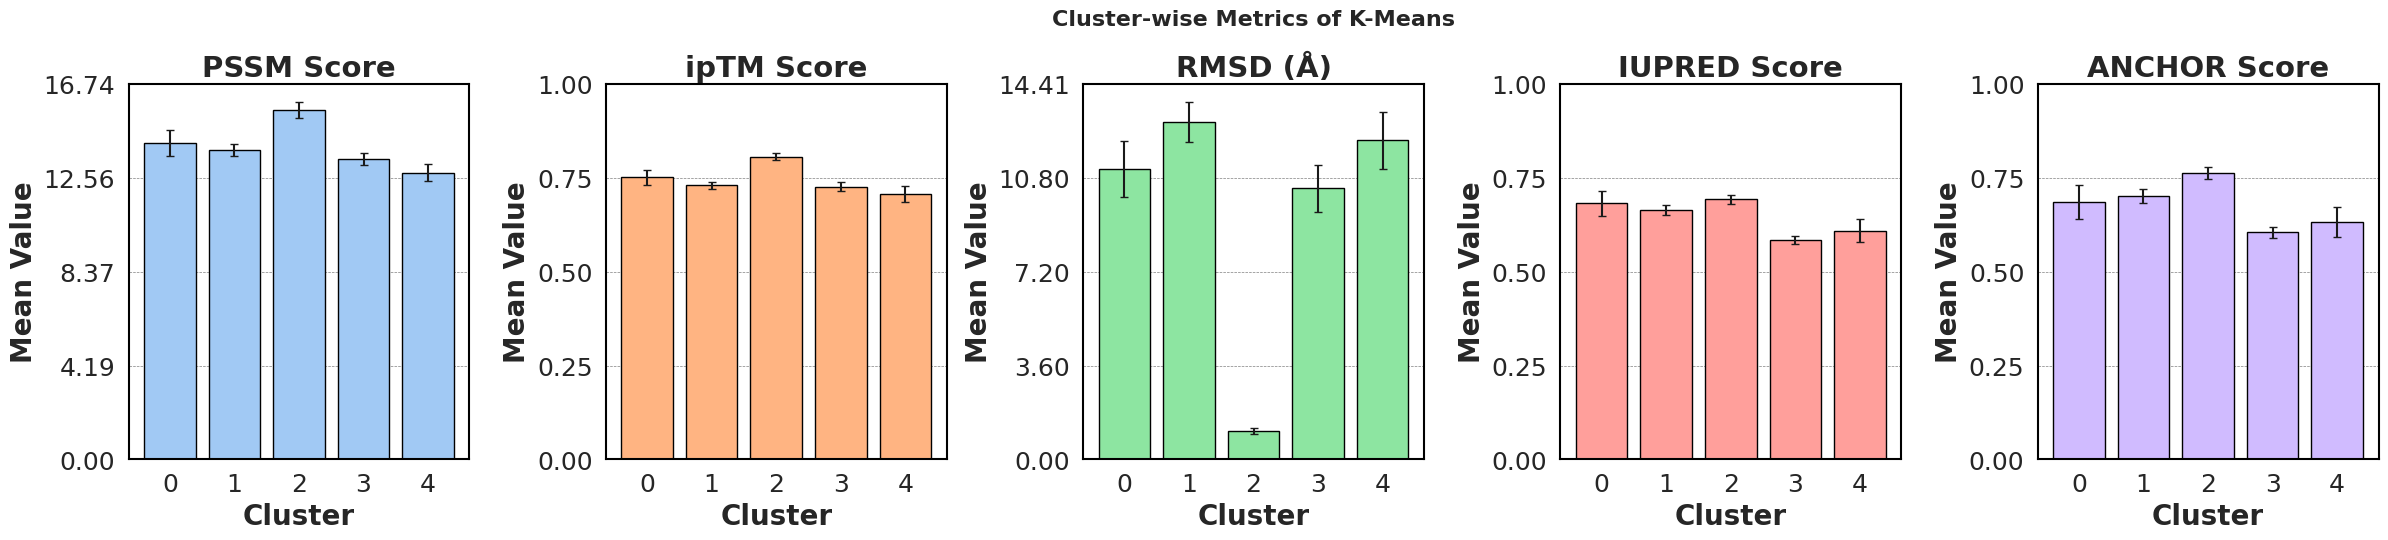

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import clustering algorithms and evaluation metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

# For plotting ellipses
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib as mpl
# Reset all matplotlib settings to their default values
mpl.rcParams.update(mpl.rcParamsDefault)
clusters=5

# Read the data
data = pd.read_csv(file_path)

# Extract relevant columns
mean_delta_theta = data['Mean_Delta_Theta']
mean_delta_phi = data['Mean_Delta_Phi']
mean_helix_polarity = data['Mean_Helix_Polarity']
mean_rmsd = np.log1p(data['Mean_RMSD'])

# Combine features into a single DataFrame
X = pd.DataFrame({
    'Mean_Delta_Theta': mean_delta_theta,
    'Mean_Delta_Phi': mean_delta_phi,
    'Mean_Helix_Polarity': mean_helix_polarity,
    'Mean_RMSD': mean_rmsd
})

# Handle missing values (if any)
X = X.dropna()

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert X_scaled back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Define feature weights (replace these with your actual weights)
feature_weights = {
    'Mean_Delta_Theta': 1,    # Adjust weights based on your PCA results
    'Mean_Delta_Phi': 1,
    'Mean_Helix_Polarity': 1,
    'Mean_RMSD': 1
}

# Apply feature weights
for feature in X_scaled_df.columns:
    weight = feature_weights.get(feature)
    X_scaled_df[feature] *= weight

# Convert back to NumPy array for clustering algorithms
X_weighted = X_scaled_df.values

# Perform Agglomerative Clustering with 4 clusters
agg = AgglomerativeClustering(n_clusters=clusters)
labels = agg.fit_predict(X_weighted)

# Add cluster labels to data
data['Cluster'] = labels

# For plotting, extract relevant columns
plot_data = pd.DataFrame({
    'Mean_Delta_Phi': mean_delta_phi,
    'Mean_Delta_Theta': mean_delta_theta,
    'Cluster': labels,
    'Mean_Helix_Polarity': mean_helix_polarity,
    'Mean_RMSD': mean_rmsd # This should be the transformed Mean_RMSD
})

# Define colors for clusters
num_clusters = len(np.unique(labels))
colors = sns.color_palette('Set1', n_colors=num_clusters)

# Create a figure with a 2D plot and a 3D plot
fig = plt.figure(figsize=(18, 7), constrained_layout=True)

# Add a central title
fig.suptitle('Agglomerative Clustering', fontsize=16, fontweight='bold')

# 3D Scatter Plot
ax3d = fig.add_subplot(1, 2, 1, projection='3d')

# 3D scatter plot with cluster colors
for cluster in range(num_clusters):
    cluster_data = plot_data[plot_data['Cluster'] == cluster]
    ax3d.scatter(cluster_data['Mean_Delta_Theta'], 
                 cluster_data['Mean_Delta_Phi'], 
                 cluster_data['Mean_Helix_Polarity'],
                 color=colors[cluster], edgecolor='k', s=50, label=f'Cluster {cluster}')

# Set labels for the axes and the title
ax3d.set_xlabel(r'$\boldsymbol{\Delta\theta} \, \boldsymbol{(°)}$', fontsize=15, fontweight='bold')
ax3d.set_ylabel(r'$\boldsymbol{\Delta\phi} \, \boldsymbol{(°)}$', fontsize=15, fontweight='bold')
ax3d.set_zlabel('Helix Polarity', fontsize=15, fontweight='bold')
ax3d.set_title('3D Conformational Space (ΔΘ, ΔΦ, Polarity)', fontsize=16, fontweight='bold', x=0.6)

# Adjust the thickness of the gridlines and axis lines
ax3d.tick_params(axis='x', colors='black', width=1.5)
ax3d.tick_params(axis='y', colors='black', width=1.5)
ax3d.tick_params(axis='z', colors='black', width=1.5)

ax3d.grid(True, linewidth=1.5)
ax3d.grid(color='gray', linestyle='--', linewidth=0.3)

# Make axis lines black and thicker
ax3d.xaxis._axinfo["axisline"]["color"] = (0,0,0,1)  # Black
ax3d.xaxis._axinfo["axisline"]["linewidth"] = 2.0

ax3d.yaxis._axinfo["axisline"]["color"] = (0,0,0,1)  # Black
ax3d.yaxis._axinfo["axisline"]["linewidth"] = 2.0

ax3d.zaxis._axinfo["axisline"]["color"] = (0,0,0,1)  # Black
ax3d.zaxis._axinfo["axisline"]["linewidth"] = 2.0

# Adjust the ticks for the axes
ax3d.set_zticks([-1, 0, 1])  # Helix polarity axis: only +1 and -1
ax3d.set_yticks(np.arange(-200, 201, 100))  # Delta Phi axis: ticks in -100 steps

# Adjust tick size and font
ax3d.tick_params(axis='both', which='major', length=8, width=1.5, labelsize=12)
ax3d.tick_params(axis='both', which='minor', length=4, width=1.0, labelsize=10)

# Reference lines
ax3d.plot([0, 0], [-200, 200], [1.0, 1.0], color='black', linestyle=(0, (5, 5)), linewidth=1.2)
ax3d.plot([-80, 40], [0, 0], [1.0, 1.0], color='black', linestyle=(0, (5, 5)), linewidth=1.2)
ax3d.plot([0, 0], [0, 0], [-1, 1.2], color='black', linestyle=(0, (5, 5)), linewidth=1.2)

#Add legend
ax3d.legend(loc='lower right', fontsize=10, bbox_to_anchor=(1.15, 0))

# Save the updated DataFrame to a CSV file
output_file_name = 'all_combined_results_with_Kmeans_clusters.csv'  # Desired output file name
output_filtered_csv_path = os.path.join(output_directory, output_file_name)  # Combine directory and file name
data.to_csv(output_filtered_csv_path, index=False)



# 2D Plot: K-means Clustering
ax2d = fig.add_subplot(1, 2, 2)
for cluster in range(len(np.unique(labels))):
    cluster_data = data[data['Cluster'] == cluster]
    ax2d.scatter(cluster_data['Mean_Delta_Theta'], cluster_data['Mean_Delta_Phi'],
                color=colors[cluster], edgecolor='k', s=50, label=f'Cluster {cluster}')
ax2d.set_xlabel(r'$\boldsymbol{\Delta\theta} \, \boldsymbol{(°)}$', fontsize=13, fontweight='bold')
ax2d.set_ylabel(r'$\boldsymbol{\Delta\phi} \, \boldsymbol{(°)}$', fontsize=13, fontweight='bold')
ax2d.set_title('2D Scatter Plot', fontsize=14, fontweight='bold')
ax2d.grid(color='gray', linestyle='--', linewidth=0.3)

ax2d.axhline(0, color='black', linestyle=(0, (5, 5)), linewidth=1.2)  # Dashed Phi=0 line
ax2d.axvline(0, color='black', linestyle=(0, (5, 5)), linewidth=1.2)  # Dashed Theta=0 line

# Adjust tick size and font
ax2d.tick_params(axis='both', which='major', length=8, width=1.5, labelsize=12)  # Major ticks
ax2d.tick_params(axis='both', which='minor', length=4, width=1.0, labelsize=10)  # Minor ticks (optional)

# Adjust graph (line) thickness
ax2d.spines['top'].set_linewidth(1.5)  # Top border
ax2d.spines['right'].set_linewidth(1.5)  # Right border
ax2d.spines['left'].set_linewidth(1.5)  # Left border
ax2d.spines['bottom'].set_linewidth(1.5)  # Bottom border

ax2d.legend()

# Save the updated DataFrame to a CSV file
output_file_name = 'all_combined_results_with_Agglomerative_clusters.csv'  # Desired output file name
output_filtered_csv_path = os.path.join(output_directory, output_file_name)  # Combine directory and file name
data.to_csv(output_filtered_csv_path, index=False)

# Save the figure (optional)
fig.savefig(os.path.join(output_directory, "Agglomerative_Cluster.eps"), format='eps', dpi=300, bbox_inches="tight")
fig.savefig(os.path.join(output_directory, "Agglomerative_Cluster.tif"), format='tif', dpi=300, bbox_inches="tight")


# Read the clustered data
data = pd.read_csv(output_filtered_csv_path)  # Replace with your actual file path

# Relevant columns
metrics = [
    "PSSM_Score",
    "Mean_ipTM",
    "Mean_RMSD",
#    "Helix_Score",
#    "Coil_Score",
#    "Strand_Score",
    "IUPRED_Score",
    "ANCHOR_Score",
#    "Mean_Delta_Theta",
#    "Mean_Delta_Phi",
#    "Mean_Helix_Polarity",
]

# Ensure 'Cluster' column exists
if "Cluster" not in data.columns:
    raise ValueError("The 'Cluster' column is not in the dataset. Please check the input file.")

# Group by cluster and calculate mean and SEM
cluster_stats = data.groupby("Cluster")[metrics].agg(["mean", "sem"]).reset_index()

# Flatten MultiIndex columns for easier referencing
cluster_stats.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in cluster_stats.columns]

# Custom y-axis limits for certain metrics
custom_y_limits = {
    "Mean_ipTM": (0, 1),           # Example: [Min, Max]
    "Helix_Score": (0, 1),
    "Coil_Score": (0, 1),
    "Strand_Score": (0, 1),
    "IUPRED_Score": (0, 1),
    "ANCHOR_Score": (0, 1),
    "Mean_Delta_Theta": (-180, 180),
    "Mean_Delta_Phi": (-180, 180),
    "Mean_Helix_Polarity": (-1.1, 1.1),
}

# Custom titles for metrics with Greek letters and descriptive names
metric_titles = {
    "PSSM_Score": r"PSSM Score",
    "Mean_ipTM": r"ipTM Score",
    "Mean_RMSD": r"RMSD (Å)",  # Example: Adding Å for RMSD in angstroms
    "Helix_Score": r"Helix Score",
    "Coil_Score": r"Coil Score",
    "Strand_Score": r"Strand Score",
    "IUPRED_Score": r"IUPRED Score",
    "ANCHOR_Score": r"ANCHOR Score",
    "Mean_Delta_Theta": r"$\boldsymbol{\Delta\theta} \, \boldsymbol{(°)}$",  # Greek delta for Theta
    "Mean_Delta_Phi": r"$\boldsymbol{\Delta\phi} \, \boldsymbol{(°)}$",      # Greek delta for Phi
    "Mean_Helix_Polarity": r"Helix Polarity",
}

# Plotting
sns.set(style="whitegrid")  # Use a clean white grid for the background
fig, axes = plt.subplots(1, len(metrics), figsize=(25, 5))

# Adjust subplot spacing
fig.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15, wspace=0.4)  # Increase wspace for horizontal spacing

# Define a pastel color palette
palette = sns.color_palette("pastel", n_colors=len(metrics))

for i, metric in enumerate(metrics):
    ax = axes[i]
    means = cluster_stats[f"{metric}_mean"]
    sems = cluster_stats[f"{metric}_sem"]
    clusters = cluster_stats["Cluster"]
    
    # Bar plot with error bars
    bars = ax.bar(clusters, means, yerr=sems, capsize=3, color=palette[i], edgecolor="black")
    
    # Set title and labels
    title = metric_titles.get(metric, metric).replace("_", " ")
    ax.set_title(title, fontsize=21, fontweight="bold")
    ax.set_xlabel("Cluster", fontsize=20, fontweight="bold")
    ax.set_ylabel("Mean Value", fontsize=20, fontweight="bold")
    
    # Apply custom y-axis limits if specified
    if metric in custom_y_limits:
        ymin, ymax = custom_y_limits[metric]
        ax.set_ylim(ymin, ymax)
    
    # Explicitly set x-axis ticks and labels
    ax.set_xticks(clusters)  # Set ticks at the cluster positions
    ax.set_xticklabels(clusters.astype(int), fontsize=18)  # Ensure labels match the cluster numbers
    
    # Explicitly set y-axis ticks
    yticks = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 5)  # Generate 5 evenly spaced ticks
    ax.set_yticks(yticks)  # Set y-ticks
    ax.set_yticklabels([f"{tick:.2f}" for tick in yticks], fontsize=18)  # Format y-tick labels
    
    # Enable grid only for the y-axis (horizontal lines)
    ax.grid(axis="y", color="gray", linestyle="--", linewidth=0.5)  # Horizontal lines only
    ax.grid(axis="x", visible=False)  # Disable x-axis grid lines


    # Adjust the line thickness and colors
    ax.spines['bottom'].set_linewidth(1.5)  
    ax.spines['left'].set_linewidth(1.5)    
    ax.spines['right'].set_linewidth(1.5)   
    ax.spines['top'].set_linewidth(1.5)     

    ax.spines['bottom'].set_color('black')  
    ax.spines['left'].set_color('black')    
    ax.spines['right'].set_color('black')   
    ax.spines['top'].set_color('black')     

# Add a central title
fig.suptitle("Cluster-wise Metrics of K-Means", fontsize=18, fontweight="bold", y=1.02)

# Add a central title
fig.suptitle("Cluster-wise Metrics of K-Means", fontsize=16, fontweight="bold", y=1.05)

# Save the figure (optional)
fig.savefig(os.path.join(output_directory, "Agglomerative_Cluster_Metadata.eps"), format='eps', dpi=300, bbox_inches="tight")
fig.savefig(os.path.join(output_directory, "Agglomerative_Cluster_Metadata.tif"), format='tif', dpi=300, bbox_inches="tight")


# Show the plot
plt.show()

#### 7C. Clustering with HDBScan

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


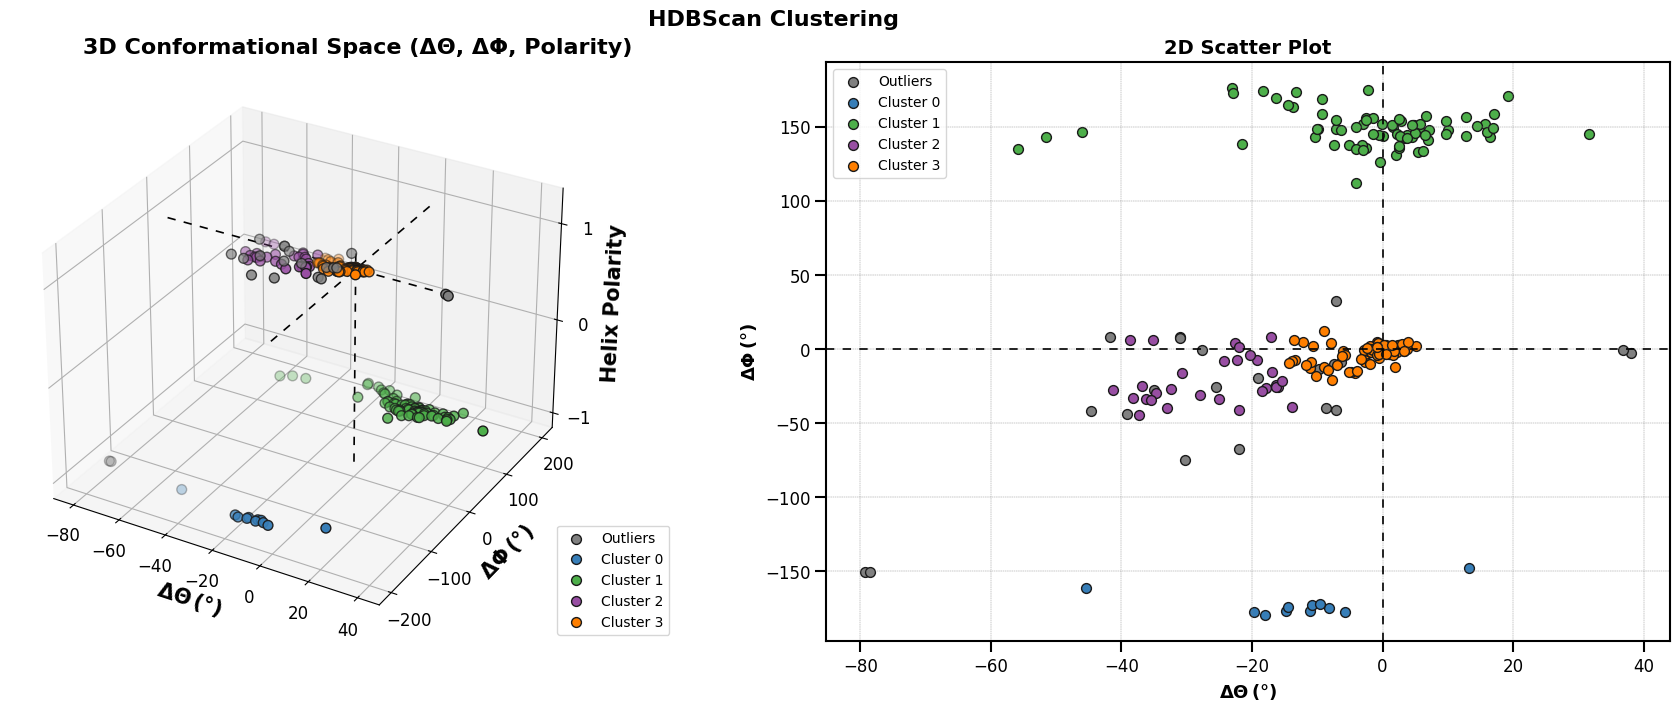

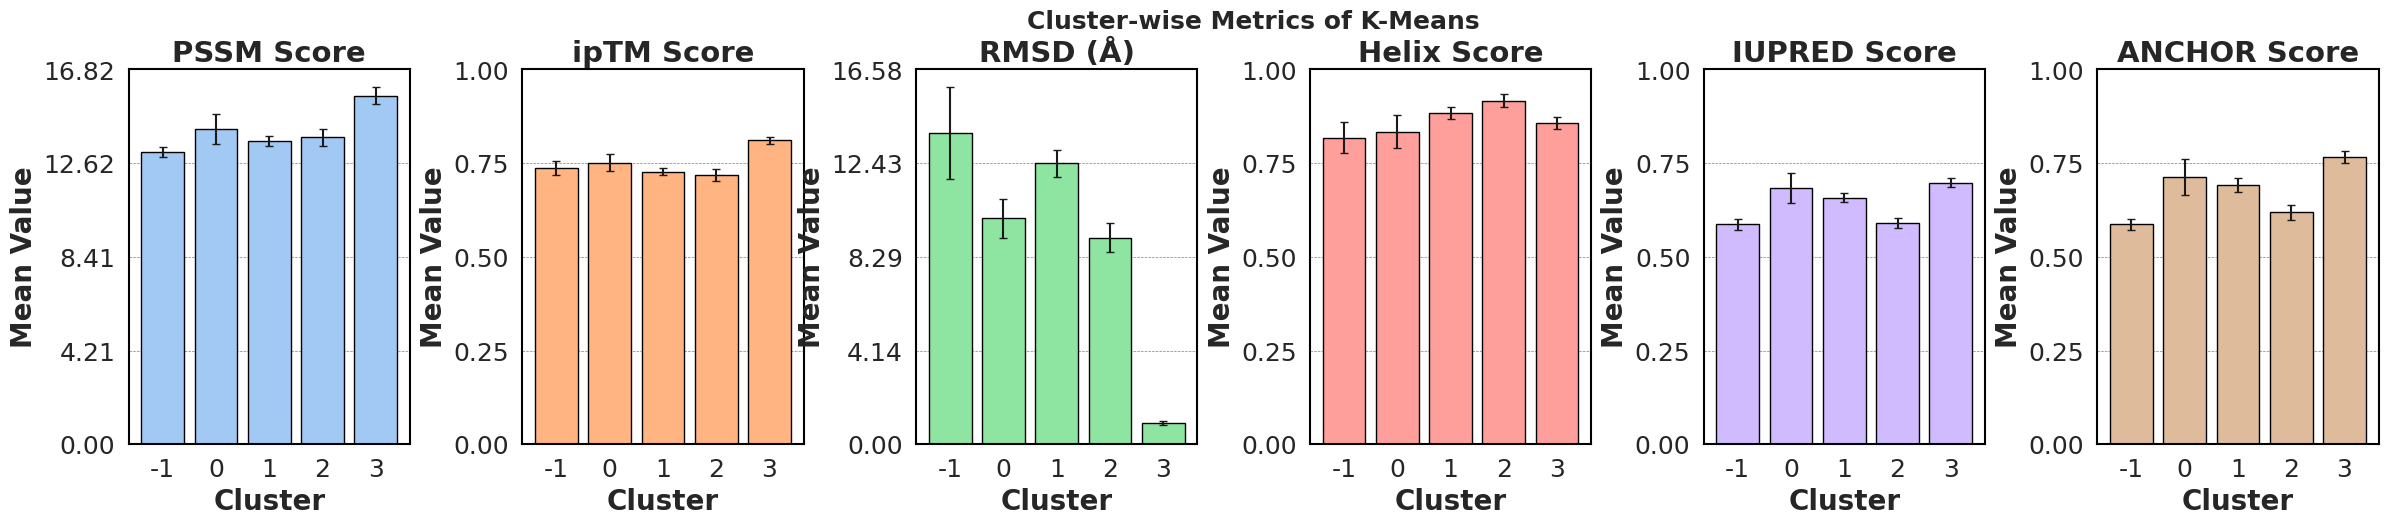

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import clustering algorithms
from sklearn.preprocessing import StandardScaler
import hdbscan
import matplotlib as mpl
# Reset all matplotlib settings to their default values
mpl.rcParams.update(mpl.rcParamsDefault)

min_cluster_size=7
min_samples=3

# Read the data
data = pd.read_csv(file_path)

# Extract relevant columns
mean_delta_theta = data['Mean_Delta_Theta']
mean_delta_phi = data['Mean_Delta_Phi']
mean_helix_polarity = data['Mean_Helix_Polarity']
mean_rmsd = np.log1p(data['Mean_RMSD'])

# Combine features into a single DataFrame
X = pd.DataFrame({
    'Mean_Delta_Theta': mean_delta_theta,
    'Mean_Delta_Phi': mean_delta_phi,
    'Mean_Helix_Polarity': mean_helix_polarity,
    'Mean_RMSD': mean_rmsd
})

# Handle missing values (if any)
X = X.dropna()

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert X_scaled back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Define feature weights (replace these with your actual weights)
feature_weights = {
    'Mean_Delta_Theta': 1,    # Adjust weights based on your PCA results
    'Mean_Delta_Phi': 1,
    'Mean_Helix_Polarity': 1,
    'Mean_RMSD': 1
}

# Apply feature weights
for feature in X_scaled_df.columns:
    weight = feature_weights.get(feature)
    X_scaled_df[feature] *= weight

# Convert back to NumPy array for clustering algorithms
X_weighted = X_scaled_df.values

# Perform HDBSCAN clustering
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
labels = hdbscan_clusterer.fit_predict(X_weighted)

# Add cluster labels to data
data['Cluster'] = labels

# For plotting, extract relevant columns
plot_data = pd.DataFrame({
    'Mean_Delta_Theta': mean_delta_theta,
    'Mean_Delta_Phi': mean_delta_phi,
    'Cluster': labels,
    'Mean_Helix_Polarity': mean_helix_polarity,
    'Mean_RMSD': mean_rmsd  # This should be the transformed Mean_RMSD
})


# Define colors for clusters, including a color for outliers (-1)
unique_labels = np.unique(labels)
num_clusters = len(unique_labels)
colors = sns.color_palette('Set1', n_colors=num_clusters)

# Map labels to colors, handling the -1 label as outliers
color_dict = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}
color_dict[-1] = 'gray'  # Use gray for outliers (label -1)

# Create a figure with a 2D plot and a 3D plot
fig = plt.figure(figsize=(18, 7), constrained_layout=True)

# Add a central title
fig.suptitle('HDBScan Clustering', fontsize=16, fontweight='bold')

# 3D Scatter Plot
ax3d = fig.add_subplot(1, 2, 1, projection='3d')

# Iterate over unique labels instead of range(num_clusters)
for label in unique_labels:
    cluster_data = plot_data[plot_data['Cluster'] == label]
    ax3d.scatter(cluster_data['Mean_Delta_Theta'], 
                 cluster_data['Mean_Delta_Phi'], 
                 cluster_data['Mean_Helix_Polarity'],
                 color=color_dict[label], edgecolor='k', s=50,
                 label=f'Cluster {label}' if label != -1 else 'Outliers')

# Set labels for the axes and the title
ax3d.set_xlabel(r'$\boldsymbol{\Delta\Theta} \, \boldsymbol{(°)}$', fontsize=15, fontweight='bold')
ax3d.set_ylabel(r'$\boldsymbol{\Delta\Phi} \, \boldsymbol{(°)}$', fontsize=15, fontweight='bold')
ax3d.set_zlabel('Helix Polarity', fontsize=15, fontweight='bold')
ax3d.set_title('3D Conformational Space (ΔΘ, ΔΦ, Polarity)', fontsize=16, fontweight='bold', x=0.6)

# Adjust the thickness of the gridlines and axis lines
ax3d.tick_params(axis='x', colors='black', width=1.5)
ax3d.tick_params(axis='y', colors='black', width=1.5)
ax3d.tick_params(axis='z', colors='black', width=1.5)

ax3d.grid(True, linewidth=1.5)
ax3d.grid(color='gray', linestyle='--', linewidth=0.3)

# Make axis lines black and thicker
ax3d.xaxis._axinfo["axisline"]["color"] = (0,0,0,1)  # Black
ax3d.xaxis._axinfo["axisline"]["linewidth"] = 2.0

ax3d.yaxis._axinfo["axisline"]["color"] = (0,0,0,1)  # Black
ax3d.yaxis._axinfo["axisline"]["linewidth"] = 2.0

ax3d.zaxis._axinfo["axisline"]["color"] = (0,0,0,1)  # Black
ax3d.zaxis._axinfo["axisline"]["linewidth"] = 2.0

# Adjust the ticks for the axes
ax3d.set_zticks([-1, 0, 1])  # Helix polarity axis: only +1 and -1
ax3d.set_yticks(np.arange(-200, 201, 100))  # Delta Phi axis: ticks in -100 steps

# Adjust tick size and font
ax3d.tick_params(axis='both', which='major', length=8, width=1.5, labelsize=12)
ax3d.tick_params(axis='both', which='minor', length=4, width=1.0, labelsize=10)

# Reference lines
ax3d.plot([0, 0], [-200, 200], [1.0, 1.0], color='black', linestyle=(0, (5, 5)), linewidth=1.2)
ax3d.plot([-80, 40], [0, 0], [1.0, 1.0], color='black', linestyle=(0, (5, 5)), linewidth=1.2)
ax3d.plot([0, 0], [0, 0], [-1, 1.2], color='black', linestyle=(0, (5, 5)), linewidth=1.2)

#Add legend
ax3d.legend(loc='lower right', fontsize=10, bbox_to_anchor=(1.15, 0))

# 2D Scatter Plot
ax2d = fig.add_subplot(1, 2, 2)

for label in unique_labels:
    cluster_data = data[data['Cluster'] == label]
    ax2d.scatter(cluster_data['Mean_Delta_Theta'], cluster_data['Mean_Delta_Phi'],
                 color=color_dict[label], edgecolor='k', s=50,
                 label=f'Cluster {label}' if label != -1 else 'Outliers')

ax2d.set_xlabel(r'$\boldsymbol{\Delta\Theta} \, \boldsymbol{(°)}$', fontsize=13, fontweight='bold')
ax2d.set_ylabel(r'$\boldsymbol{\Delta\Phi} \, \boldsymbol{(°)}$', fontsize=13, fontweight='bold')
ax2d.set_title('2D Scatter Plot', fontsize=14, fontweight='bold')
ax2d.grid(color='gray', linestyle='--', linewidth=0.3)

ax2d.axhline(0, color='black', linestyle=(0, (5, 5)), linewidth=1.2)  # Dashed Phi=0 line
ax2d.axvline(0, color='black', linestyle=(0, (5, 5)), linewidth=1.2)  # Dashed Theta=0 line

# Adjust tick size and font
ax2d.tick_params(axis='both', which='major', length=8, width=1.5, labelsize=12)  # Major ticks
ax2d.tick_params(axis='both', which='minor', length=4, width=1.0, labelsize=10)  # Minor ticks (optional)

# Adjust graph (line) thickness
ax2d.spines['top'].set_linewidth(1.5)  # Top border
ax2d.spines['right'].set_linewidth(1.5)  # Right border
ax2d.spines['left'].set_linewidth(1.5)  # Left border
ax2d.spines['bottom'].set_linewidth(1.5)  # Bottom border

ax2d.legend()

# Save the updated DataFrame to a CSV file
output_file_name = 'all_combined_results_with_HDBScan_clusters.csv'  # Desired output file name
output_filtered_csv_path = os.path.join(output_directory, output_file_name)  # Combine directory and file name
data.to_csv(output_filtered_csv_path, index=False)

# Save the figure (optional)
fig.savefig(os.path.join(output_directory, "HDBScan_Cluster.eps"), format='eps', dpi=300, bbox_inches="tight")
fig.savefig(os.path.join(output_directory, "HDBScan_Cluster.tif"), format='tif', dpi=300, bbox_inches="tight")


# Read the clustered data
data = pd.read_csv(output_filtered_csv_path)  # Replace with your actual file path

# Relevant columns
metrics = [
    "PSSM_Score",
    "Mean_ipTM",
    "Mean_RMSD",
    "Helix_Score",
 #   "Coil_Score",
 #   "Strand_Score",
    "IUPRED_Score",
    "ANCHOR_Score",
#  "Mean_Delta_Theta",
#    "Mean_Delta_Phi",
#    "Mean_Helix_Polarity",
]

# Ensure 'Cluster' column exists
if "Cluster" not in data.columns:
    raise ValueError("The 'Cluster' column is not in the dataset. Please check the input file.")

# Group by cluster and calculate mean and SEM
cluster_stats = data.groupby("Cluster")[metrics].agg(["mean", "sem"]).reset_index()

# Flatten MultiIndex columns for easier referencing
cluster_stats.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in cluster_stats.columns]

# Custom y-axis limits for certain metrics
custom_y_limits = {
    "Mean_ipTM": (0, 1),           # Example: [Min, Max]
    "Helix_Score": (0, 1),
    "Coil_Score": (0, 1),
    "Strand_Score": (0, 1),
    "IUPRED_Score": (0, 1),
    "ANCHOR_Score": (0, 1),
    "Mean_Delta_Theta": (-180, 180),
    "Mean_Delta_Phi": (-180, 180),
    "Mean_Helix_Polarity": (-1.1, 1.1),
}

# Custom titles for metrics with Greek letters and descriptive names
metric_titles = {
    "PSSM_Score": r"PSSM Score",
    "Mean_ipTM": r"ipTM Score",
    "Mean_RMSD": r"RMSD (Å)",  # Example: Adding Å for RMSD in angstroms
    "Helix_Score": r"Helix Score",
    "Coil_Score": r"Coil Score",
    "Strand_Score": r"Strand Score",
    "IUPRED_Score": r"IUPRED Score",
    "ANCHOR_Score": r"ANCHOR Score",
    "Mean_Delta_Theta": r"$\boldsymbol{\Delta\Theta} \, \boldsymbol{(°)}$",  # Greek delta for Theta
    "Mean_Delta_Phi": r"$\boldsymbol{\Delta\Phi} \, \boldsymbol{(°)}$",      # Greek delta for Phi
    "Mean_Helix_Polarity": r"Helix Polarity",
}

# Plotting
sns.set(style="whitegrid")  # Use a clean white grid for the background
fig, axes = plt.subplots(1, len(metrics), figsize=(25, 5))

# Adjust subplot spacing
fig.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15, wspace=0.4)  # Increase wspace for horizontal spacing

# Define a pastel color palette
palette = sns.color_palette("pastel", n_colors=len(metrics))

for i, metric in enumerate(metrics):
    ax = axes[i]
    means = cluster_stats[f"{metric}_mean"]
    sems = cluster_stats[f"{metric}_sem"]
    clusters = cluster_stats["Cluster"]
    
    # Bar plot with error bars
    bars = ax.bar(clusters, means, yerr=sems, capsize=3, color=palette[i], edgecolor="black")
    
    # Set title and labels
    title = metric_titles.get(metric, metric).replace("_", " ")
    ax.set_title(title, fontsize=21, fontweight="bold")
    ax.set_xlabel("Cluster", fontsize=20, fontweight="bold")
    ax.set_ylabel("Mean Value", fontsize=20, fontweight="bold")
    
    # Apply custom y-axis limits if specified
    if metric in custom_y_limits:
        ymin, ymax = custom_y_limits[metric]
        ax.set_ylim(ymin, ymax)
    
    # Explicitly set x-axis ticks and labels
    ax.set_xticks(clusters)  # Set ticks at the cluster positions
    ax.set_xticklabels(clusters.astype(int), fontsize=18)  # Ensure labels match the cluster numbers
    
    # Explicitly set y-axis ticks
    yticks = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 5)  # Generate 5 evenly spaced ticks
    ax.set_yticks(yticks)  # Set y-ticks
    ax.set_yticklabels([f"{tick:.2f}" for tick in yticks], fontsize=18)  # Format y-tick labels
    
    # Enable grid only for the y-axis (horizontal lines)
    ax.grid(axis="y", color="gray", linestyle="--", linewidth=0.5)  # Horizontal lines only
    ax.grid(axis="x", visible=False)  # Disable x-axis grid lines


    # Adjust the line thickness and colors
    ax.spines['bottom'].set_linewidth(1.5)  
    ax.spines['left'].set_linewidth(1.5)    
    ax.spines['right'].set_linewidth(1.5)   
    ax.spines['top'].set_linewidth(1.5)     

    ax.spines['bottom'].set_color('black')  
    ax.spines['left'].set_color('black')    
    ax.spines['right'].set_color('black')   
    ax.spines['top'].set_color('black')     

# Add a central title
fig.suptitle("Cluster-wise Metrics of K-Means", fontsize=18, fontweight="bold", y=1.02)

# Save the figure (optional)
fig.savefig(os.path.join(output_directory, "HDBScan_Cluster_Metadata.eps"), format='eps', dpi=300, bbox_inches="tight")
fig.savefig(os.path.join(output_directory, "HDBScan_Cluster_Metadata.tif"), format='tif', dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


#### 8. Extract and Visualize PDB Files for Specific Clusters
##### This script allows users to query the clustermethod in favor for a specific cluster of interest from a dataset containing PDB filenames and cluster assignments. It extracts the corresponding PDB files, saves the list to a text file, and generates a PyMOL script for visualization. 

In [69]:
import pandas as pd
import os
import glob

# Map user choices to corresponding CSV files
csv_options = {
    'h': 'all_combined_results_with_HDBScan_clusters.csv',
    'k': 'all_combined_results_with_Kmeans_clusters.csv',
    'a': 'all_combined_results_with_Agglomerative_clusters.csv'
}

# Ask the user which CSV to use
clustering_choice = input("Enter 'h' for HDBScan, 'k' for K-means, or 'a' for Agglomerative: ").strip().lower()

if clustering_choice not in csv_options:
    raise ValueError("Invalid choice. Please enter 'h', 'k', or 'a'.")

# Build the full CSV file path
csv_file_path = os.path.join(output_directory, csv_options[clustering_choice])

# Set the cluster you want to open
open_cluster = int(input("Enter the cluster number for loading structures in PyMOL: ").strip())

# Read the selected CSV file
df = pd.read_csv(csv_file_path)

# Filter the DataFrame to only include entries from the desired cluster
cluster_df = df[df['Cluster'] == open_cluster]

# Initialize a list to store PDB file paths
pdb_files_to_load = []

# Iterate over the entries in the cluster
for index, row in cluster_df.iterrows():
    folder_name = row['Folder']  # Assuming 'Folder' column has folder names
    # Construct the full path to the folder
    folder_path = os.path.join(zip_files_folder, folder_name)
    # Check if the folder exists
    if os.path.exists(folder_path):
        # Search for PDB files containing 'unrelaxed_rank_001' in their names
        pdb_pattern = os.path.join(folder_path, '**', '*unrelaxed_rank_001*.pdb')
        pdb_files = glob.glob(pdb_pattern, recursive=True)
        # Normalize paths to ensure consistency
        pdb_files = [os.path.normpath(pdb) for pdb in pdb_files]
        # Add PDB files to the list
        pdb_files_to_load.extend(pdb_files)
    else:
        print(f"Folder not found: {folder_path}")

# Create a filename with the cluster name included. 
pymol_script_path = os.path.join(output_directory, f"HDBScan_cluster_{open_cluster}_structures.pml")

# Write a PyMOL script to load all the PDB files
with open(pymol_script_path, 'w') as f:
    for pdb_file in pdb_files_to_load:
        # Escape backslashes in the path for PyMOL compatibility
        escaped_path = pdb_file.replace('\\', '/')
        # Write the PyMOL command to load the PDB file
        f.write(f'load "{escaped_path}"\n')

print(f"PyMOL script written to {pymol_script_path}")
print(f"Number of structures to load: {len(pdb_files_to_load)}")

PyMOL script written to /media/pythagoras/895c7a01-1c19-48a4-9803-d0d6a1c1a979/PhD/Pulldown/Paper/Iteration01/Iteration01/HDBScan_cluster_3_structures.pml
Number of structures to load: 77


#### 9. Open in PyMol and check for structural alignment manually 
command you can use for that: 
```
for obj in cmd.get_object_list(): cmd.align(f"{obj} and chain B", "c_NP_002211.1_pos_31_unrelaxed_rank_001_alphafold2_multimer_v3_model_4_seed_000 and chain B")
```

or

```
for obj in cmd.get_object_list(): cmd.align(f"{obj} and chain B", "c_NP_002211.1_pos_31 and chain B")
```


or save this as a script, as the above commands might not work: 
```
for obj in cmd.get_object_list():
    cmd.align(f"model '{obj}' and chain B", "model 'c_NP_002211.1_pos_31' and chain B")
```

#### 10. Generate FASTA File for Clustered Sequences

In [71]:
import pandas as pd
import os
import glob
from Bio.PDB import PDBParser, is_aa
from Bio.SeqUtils import seq1
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

# Map user choices to corresponding CSV files
csv_options = {
    'h': 'all_combined_results_with_HDBScan_clusters.csv',
    'k': 'all_combined_results_with_Kmeans_clusters.csv',
    'a': 'all_combined_results_with_Agglomerative_clusters.csv'
}

# Prompt user for the method
clustering_choice = input("Enter 'h' for HDBScan, 'k' for K-means, or 'a' for Agglomerative: ").strip().lower()
if clustering_choice not in csv_options:
    raise ValueError("Invalid choice. Please enter 'h', 'k', or 'a'.")

# Prompt for the cluster number
open_cluster = int(input("Enter the cluster number for extracting sequences: ").strip())

# Determine CSV file path based on user choice
csv_file_path = os.path.join(output_directory, csv_options[clustering_choice])

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Filter the DataFrame to only include entries from the desired cluster
cluster_df = df[df['Cluster'] == open_cluster]

# Initialize a list to store SeqRecord objects
seq_records = []

# Create a PDBParser
parser = PDBParser(QUIET=True)

# Iterate over the entries in the cluster
for index, row in cluster_df.iterrows():
    folder_name = row['Folder']  # Assuming 'Folder' column has folder names
    # Extract additional information from the row
    name = row.get('Name', 'N/A')
    position = row.get('Position', 'N/A')
    pssm_score = row.get('PSSM_Score', 'N/A')
    iupred_score = row.get('IUPRED_Score', 'N/A')
    anchor_score = row.get('ANCHOR_Score', 'N/A')
    coil_score = row.get('Coil_Score', 'N/A')
    helix_score = row.get('Helix_Score', 'N/A')
    strand_score = row.get('Strand_Score', 'N/A')
    mean_pLDDT = row.get('Mean_pLDDT', 'N/A')
    mean_pTM = row.get('Mean_pTM', 'N/A')
    mean_ipTM = row.get('Mean_ipTM', 'N/A')
    mean_RMSD = row.get('Mean_RMSD', 'N/A')
    mean_Delta_Theta = row.get('Mean_Delta_Theta', 'N/A')
    mean_Delta_Phi = row.get('Mean_Delta_Phi', 'N/A')
    mean_Helix_Polarity = row.get('Mean_Helix_Polarity', 'N/A')

    # Construct a description string with all the information
    description = (
        f"Name:{name} Position:{position} PSSM_Score:{pssm_score} "
        f"IUPRED_Score:{iupred_score} ANCHOR_Score:{anchor_score} "
        f"Coil_Score:{coil_score} Helix_Score:{helix_score} Strand_Score:{strand_score} "
        f"Mean_pLDDT:{mean_pLDDT} Mean_pTM:{mean_pTM} Mean_ipTM:{mean_ipTM} "
        f"Mean_RMSD:{mean_RMSD} Mean_Delta_Theta:{mean_Delta_Theta} "
        f"Mean_Delta_Phi:{mean_Delta_Phi} Mean_Helix_Polarity:{mean_Helix_Polarity}"
    )

    # Construct the full path to the folder
    folder_path = os.path.join(zip_files_folder, folder_name)
    # Check if the folder exists
    if os.path.exists(folder_path):
        # Search for PDB files containing 'unrelaxed_rank_001' in their names
        pdb_pattern = os.path.join(folder_path, '**', '*unrelaxed_rank_001*.pdb')
        pdb_files = glob.glob(pdb_pattern, recursive=True)
        # Normalize paths to ensure consistency
        pdb_files = [os.path.normpath(pdb) for pdb in pdb_files]
        # Process each PDB file
        for pdb_file in pdb_files:
            try:
                structure = parser.get_structure('', pdb_file)
                # Assume model 0
                model = structure[0]
                # Get chain A
                chainA = model['A']
                # Extract the sequence
                residues = []
                for residue in chainA:
                    if is_aa(residue, standard=True):
                        res_name = residue.get_resname()
                        # Convert three-letter code to one-letter code
                        res_short = seq1(res_name)
                        residues.append(res_short)
                seq_one_letter = ''.join(residues)
                # Create a SeqRecord with an informative ID and full description
                seq_id = os.path.basename(pdb_file).split('.')[0]  # Filename without extension
                seq_record = SeqRecord(Seq(seq_one_letter), id=seq_id, description=description)
                seq_records.append(seq_record)
            except Exception as e:
                print(f"Error processing PDB file {pdb_file}: {e}")
    else:
        print(f"Folder not found: {folder_path}")

# Write sequences to a FASTA file with separate entries
fasta_output_path = os.path.join(output_directory, f'cluster_{open_cluster}_sequences.fasta')

with open(fasta_output_path, 'w') as f:
    SeqIO.write(seq_records, f, 'fasta')

print(f"\nSequences from cluster {open_cluster} have been written to:\n{fasta_output_path}")



Sequences from cluster 3 have been written to:
/media/pythagoras/895c7a01-1c19-48a4-9803-d0d6a1c1a979/PhD/Pulldown/Paper/Iteration01/Iteration01/cluster_3_sequences.fasta


#### 11. Link the Fasta from the Cluster with the redundant .fasta from the PSSM Search and retrieve all Gene Names

In [4]:
non_redundant_fasta = "/media/pythagoras/895c7a01-1c19-48a4-9803-d0d6a1c1a979/PhD/Pulldown/Paper/Iteration01/Iteration01/cluster_3_sequences.fasta"  # Non-redundant sequences
redundant_fasta = "/media/pythagoras/895c7a01-1c19-48a4-9803-d0d6a1c1a979/PhD/Pulldown/Paper/Iteration01/Iteration01/Output/PSSM/PSSM.fasta"  # Redundant fasta file

from Bio import SeqIO
from Bio import Entrez
from collections import defaultdict
import time

# Configure NCBI email and API key
Entrez.email = "themistoklis.paraschiakos@gmail.com"  # Replace with your email
Entrez.api_key = "21994fff4aa18a624e4f2a5ccb4441f24e09"  # Replace with your API key (optional)


# Dynamically construct output file paths
output_fasta = os.path.join(output_directory, "annotated_sequences.fasta")  # Annotated sequences
output_summary = os.path.join(output_directory, "sequence_gene_names.txt")  # Sequence to gene names mapping
output_gene_list = os.path.join(output_directory, "unique_gene_names.txt")  # List of unique gene names

def extract_protein_id(record):
    """
    Extract the protein ID from the record.
    """
    # Try to get protein ID from 'Name:' in description
    for part in record.description.split():
        if "Name:" in part:
            return part.split("Name:")[1]
    # If not found, use record.id
    return record.id

def fetch_gene_name(protein_id, gene_name_cache):
    """
    Fetch the gene name from NCBI using the protein ID, with caching.
    """
    if protein_id in gene_name_cache:
        return gene_name_cache[protein_id]
    try:
        # Use Entrez.efetch to get the protein record in XML format
        handle = Entrez.efetch(db="protein", id=protein_id, rettype="gp", retmode="xml")
        records = Entrez.read(handle)
        handle.close()
        
        # Navigate the XML structure to find the gene name
        gene_name = "Unknown"
        for feature in records[0]['GBSeq_feature-table']:
            if feature['GBFeature_key'] == 'Gene':
                for qualifier in feature['GBFeature_quals']:
                    if qualifier['GBQualifier_name'] == 'gene':
                        gene_name = qualifier['GBQualifier_value']
                        gene_name_cache[protein_id] = gene_name
                        return gene_name
            elif feature['GBFeature_key'] == 'CDS':
                for qualifier in feature['GBFeature_quals']:
                    if qualifier['GBQualifier_name'] == 'gene':
                        gene_name = qualifier['GBQualifier_value']
                        gene_name_cache[protein_id] = gene_name
                        return gene_name
        gene_name_cache[protein_id] = gene_name
        return gene_name
    except Exception as e:
        print(f"Error fetching gene name for {protein_id}: {e}")
        gene_name_cache[protein_id] = "Error"
        return "Error"
    finally:
        time.sleep(0.1)  # Adjust based on NCBI rate limits

# Step 1: Build a mapping from sequence string to set of protein IDs from the redundant fasta file
sequence_to_protein_ids = defaultdict(set)

with open(redundant_fasta, "r") as red_file:
    for record in SeqIO.parse(red_file, "fasta"):
        seq_str = str(record.seq)
        protein_id = extract_protein_id(record)
        sequence_to_protein_ids[seq_str].add(protein_id)

# Initialize data structures
annotated_records = []
sequence_to_gene_names = {}
processed_count = 0
gene_name_cache = {}  # Cache to avoid redundant API calls

# Step 2: Process the non-redundant fasta file
with open(non_redundant_fasta, "r") as nr_file:
    for record in SeqIO.parse(nr_file, "fasta"):
        seq_str = str(record.seq)
        matching_protein_ids = sequence_to_protein_ids.get(seq_str, set())
        gene_names = set()
        for protein_id in matching_protein_ids:
            gene_name = fetch_gene_name(protein_id, gene_name_cache)
            if gene_name not in ["Unknown", "Error"]:
                gene_names.add(gene_name)
        # Annotate the record with the gene names
        gene_names_str = ", ".join(sorted(gene_names)) if gene_names else "Unknown"
        record.description += f" | Gene(s): {gene_names_str}"
        # Add the record to the list
        annotated_records.append(record)
        # Store the mapping for the summary
        sequence_to_gene_names[record.id] = {
            'protein_ids': matching_protein_ids,
            'gene_names': gene_names if gene_names else {"Unknown"}
        }
        processed_count += 1
        # Print progress every 10 sequences
        if processed_count % 10 == 0:
            print(f"Processed {processed_count} sequences")

# Step 3: Write the annotated sequences to the output FASTA file
with open(output_fasta, "w") as output_fasta_file:
    SeqIO.write(annotated_records, output_fasta_file, "fasta")

# Step 4: Write the sequence to gene names mapping to a summary file
with open(output_summary, "w") as summary_file:
    for seq_id, info in sequence_to_gene_names.items():
        protein_ids_str = ", ".join(info['protein_ids'])
        gene_names_str = ", ".join(sorted(info['gene_names'])) if info['gene_names'] else "Unknown"
        summary_file.write(f"Sequence ID: {seq_id}\n")
        summary_file.write(f"Protein IDs: {protein_ids_str}\n")
        summary_file.write(f"Gene Names: {gene_names_str}\n")
        summary_file.write("-" * 40 + "\n")

# Step 5: Create a set of unique gene names
unique_genes = set()
for info in sequence_to_gene_names.values():
    unique_genes.update(info['gene_names'])

# Write the unique gene names to a file
with open(output_gene_list, "w") as gene_list_file:
    for gene_name in sorted(unique_genes):
        gene_list_file.write(f"{gene_name}\n")

# Print summary statistics
total_sequences = len(sequence_to_gene_names)
print(f"Summary:")
print(f" - Total sequences processed: {total_sequences}")
print(f" - Total unique genes found: {len(unique_genes)}")
print(f"Results written to:")
print(f" - Annotated FASTA: {output_fasta}")
print(f" - Sequence to Gene Names Mapping: {output_summary}")
print(f" - Unique Gene Names List: {output_gene_list}")


Processed 10 sequences
Processed 20 sequences
Processed 30 sequences
Processed 40 sequences
Processed 50 sequences
Processed 60 sequences
Summary:
 - Total sequences processed: 65
 - Total unique genes found: 47
Results written to:
 - Annotated FASTA: /media/pythagoras/895c7a01-1c19-48a4-9803-d0d6a1c1a979/PhD/Pulldown/Paper/Iteration01/Iteration01/annotated_sequences.fasta
 - Sequence to Gene Names Mapping: /media/pythagoras/895c7a01-1c19-48a4-9803-d0d6a1c1a979/PhD/Pulldown/Paper/Iteration01/Iteration01/sequence_gene_names.txt
 - Unique Gene Names List: /media/pythagoras/895c7a01-1c19-48a4-9803-d0d6a1c1a979/PhD/Pulldown/Paper/Iteration01/Iteration01/unique_gene_names.txt
